# Analysis of DRAGON networks for colorectal cancer Consensus Molecular Subtypes

In this notebook we are reproducing the colon cancer subtype results of the "Reproducible processing of TCGA regulatory
networks" paper.

After generating DRAGON networks for the four major consensus subtypes (CMS1 to CMS4) we proceed to analyze these
networks. We are interested in investigating whether complex multi-omics associations can explain the different
phenotypes of the four groups, and in particular the worse prognostics of CMS4.

First we are going to import some packages and define some functions. Go to section [Read the data](#read-the-data).

The utility functions are stored inside the `utils.py` file that is imported at the beginning of the notebook. 



#### Table of Content


- [Read the data](#read-the-data)
- [Load and clean the data](#load-and-clean-the-data)
- [DRAGON "TRANS": methylation to expression](#dragon-trans-methylation-to-expression)
- [Relationship between promoter methylation and TF expression](#relationship-between-promoter-methylation-and-tf-expression)
- [Clustering methylation to expression edges on different TFs](#clustering-methylation-to-expression-edges-on-different-tfs)
- [Analysis and visualization of the different clusters](#analysis-and-visualization-of-the-different-clusters)
- [Pathways for each cluster](pathways-for-each-cluster)

In [4]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import gseapy as gp
import networkx as nx
import os

# this is necessary only for better label positioning
!pip install adjustText

In [5]:
# import all functions from utils.py that is inside src folder
from src.utils import *

## Load and clean the data

Here we are using the dragon networks generated by the `tcga-data-nf` workflow, run with the `full` pipeline. 

The folder of the data is `batch-coad-subtype-20240510/` at ([myurl](myurl)).
You can download the results inside the `data/processed/`.

Configuration files used to generate the networks are inside the `conf/` folder. 

All results are gonna be stored inside the `results/dragon-post/` folder. However, the user can set any output folder
they want.

In [6]:
# Set output folder
output_folder = '../results/cms-post/'
# Check if folder exists
if os.path.exists(output_folder):
    print('Folder exists')
else:
    os.mkdir(output_folder)

In [7]:
# dictionary of file names for all dragons of interest
# This needs you to have downloaded the data from the storage

dragon_fn  = {'cms1':'../data/processed/batch-coad-subtype-20240510/tcga_coad_cms1/analysis/dragon/tcga_coad_cms1_dragon_mat.tsv',
             'cms2': '../data/processed/batch-coad-subtype-20240510/tcga_coad_cms2/analysis/dragon/tcga_coad_cms2_dragon_mat.tsv',
             'cms3': '../data/processed/batch-coad-subtype-20240510/tcga_coad_cms3/analysis/dragon/tcga_coad_cms3_dragon_mat.tsv',
             'cms4': '../data/processed/batch-coad-subtype-20240510/tcga_coad_cms4/analysis/dragon/tcga_coad_cms4_dragon_mat.tsv'}

In [8]:
# Read the dragons with the function from utils.py
dragons = read_dragons(dragon_fn)

cms1
cms2
cms3
cms4


In [9]:
# This is what a dragon looks like. 
# It is a dataframe with the TF name + modality names in the columns and rows.
# The matrix is symmetric

dragons['cms1'].head()

AC023509.3_methylation  AC092835.1_methylation  \
AC023509.3_methylation                0.000000                0.010079   
AC092835.1_methylation                0.010079                0.000000   
AC138696.1_methylation                0.001609                0.001370   
AEBP1_methylation                    -0.001914                0.008169   
AEBP2_methylation                     0.002398                0.007796   

                        AC138696.1_methylation  AEBP1_methylation  \
AC023509.3_methylation                0.001609          -0.001914   
AC092835.1_methylation                0.001370           0.008169   
AC138696.1_methylation                0.000000          -0.003199   
AEBP1_methylation                    -0.003199           0.000000   
AEBP2_methylation                     0.002904           0.000252   

                        AEBP2_methylation  AHDC1_methylation  \
AC023509.3_methylation           0.002398           0.004454   
AC092835.1_methylation           0.007796           0.005386   
AC138696.1_methylation           0.002904           0.007150   
AEBP1_methylation                0.000252          -0.000029   
AEBP2_methylation                0.000000          -0.008129   

                        AIRE_methylation  AKAP8_methylation  \
AC023509.3_methylation         -0.008123           0.000519   
AC092835.1_methylation         -0.016066           0.001738   
AC138696.1_methylation          0.003810           0.009145   
AEBP1_methylation               0.001248          -0.001056   
AEBP2_methylation               0.002362          -0.002671   

                        AKAP8L_methylation  AKNA_methylation  ...  \
AC023509.3_methylation            0.003486          0.002348  ...   
AC092835.1_methylation            0.001990          0.000933  ...   
AC138696.1_methylation            0.017653         -0.002921  ...   
AEBP1_methylation                -0.001047          0.002113  ...   
AEBP2_methylation                 0.001363         -0.002856  ...   

                        ZNF84_expression  ZNF853_expression  \
AC023509.3_methylation         -0.001641          -0.007480   
AC092835.1_methylation         -0.001513          -0.000493   
AC138696.1_methylation          0.001024           0.002031   
AEBP1_methylation               0.001842          -0.003248   
AEBP2_methylation              -0.003264           0.001187   

                        ZNF860_expression  ZNF865_expression  \
AC023509.3_methylation          -0.002582           0.000422   
AC092835.1_methylation           0.001049          -0.005678   
AC138696.1_methylation          -0.000580          -0.000158   
AEBP1_methylation                0.000187          -0.001094   
AEBP2_methylation               -0.001444          -0.001279   

                        ZNF880_expression  ZSCAN16_expression  \
AC023509.3_methylation          -0.004480            0.003720   
AC092835.1_methylation          -0.001948           -0.002561   
AC138696.1_methylation           0.000832            0.000678   
AEBP1_methylation               -0.002347           -0.000410   
AEBP2_methylation                0.002488            0.002112   

                        ZSCAN22_expression  ZSCAN9_expression  \
AC023509.3_methylation            0.002558           0.003441   
AC092835.1_methylation           -0.002993          -0.005031   
AC138696.1_methylation           -0.000269          -0.002647   
AEBP1_methylation                -0.003929           0.000282   
AEBP2_methylation                -0.005443          -0.000204   

                        ZXDB_expression  ZXDC_expression  
AC023509.3_methylation        -0.001307         0.001628  
AC092835.1_methylation        -0.003344        -0.000754  
AC138696.1_methylation        -0.000910        -0.000314  
AEBP1_methylation              0.001960        -0.000154  
AEBP2_methylation             -0.000977        -0.006656  

[5 rows x 1419 columns]

In [10]:
# we need to make sure the dragons are symmetric and that nothing went wrong
assert np.isclose(dragons['cms1'].values,dragons['cms1'].T.values).all()
assert np.isclose(dragons['cms2'].values,dragons['cms2'].T.values).all()
assert np.isclose(dragons['cms3'].values,dragons['cms3'].T.values).all()
assert np.isclose(dragons['cms4'].values,dragons['cms4'].T.values).all()

In [11]:
# For simplicity we write down the order of the subtypes
subtype_order = ['cms1', 'cms2', 'cms3', 'cms4']

In [12]:
# to keep track of all the edges we will create a dataframe where subtypes are in the columns and rows are the edges
dragon = get_long_dragon(dragons)
dragon.head()

                        level_0                 level_1         0
0        AC023509.3_methylation  AC092835.1_methylation  0.010079
1        AC023509.3_methylation  AC138696.1_methylation  0.001609
2        AC023509.3_methylation       AEBP1_methylation -0.001914
3        AC023509.3_methylation       AEBP2_methylation  0.002398
4        AC023509.3_methylation       AHDC1_methylation  0.004454
...                         ...                     ...       ...
1006066      ZSCAN22_expression         ZXDB_expression  0.000783
1006067      ZSCAN22_expression         ZXDC_expression  0.003939
1006068       ZSCAN9_expression         ZXDB_expression -0.000765
1006069       ZSCAN9_expression         ZXDC_expression  0.000768
1006070         ZXDB_expression         ZXDC_expression  0.000498

[1006071 rows x 3 columns]
                          node1                   node2      cms1
0        AC023509.3_methylation  AC092835.1_methylation  0.010079
1        AC023509.3_methylation  AC138696.1_meth

node1                   node2      cms1      cms2  \
0  AC023509.3_methylation  AC092835.1_methylation  0.010079 -0.002448   
1  AC023509.3_methylation  AC138696.1_methylation  0.001609  0.008164   
2  AC023509.3_methylation        AEBP1_expression -0.005313  0.002291   
3  AC023509.3_methylation       AEBP1_methylation -0.001914 -0.004333   
4  AC023509.3_methylation        AEBP2_expression  0.001178  0.001567   

       cms3      cms4  
0 -0.012452  0.011108  
1  0.006137  0.004494  
2  0.003407 -0.005202  
3  0.000148  0.002592  
4  0.001819  0.001794

We generate a more detailed table with columns that describe average edge values, TF names...

In [13]:
# mean dragon value for all subtypes
dragon['mean']  = dragon.loc[:,subtype_order].mean(axis =1)
# absolute mean dragon value for all subtypes
dragon['abs_mean']  = np.abs(dragon.loc[:,subtype_order]).mean(axis =1)
# variance
dragon['var']  = dragon.loc[:,subtype_order].var(axis =1)

# node type, whether expression or methylation
dragon['node1_type'] = [i.split('_')[1] for i in dragon['node1']]
dragon['node2_type'] = [i.split('_')[1] for i in dragon['node2']]
# node name
dragon['node1_tf'] = [i.split('_')[0] for i in dragon['node1']]
dragon['node2_tf'] = [i.split('_')[0] for i in dragon['node2']]

# get absolute values for dragons
dragon.loc[:,[i+'_abs' for i in subtype_order]] = np.abs(dragon.loc[:,subtype_order].values)

# edge name
dragon['edge'] = dragon.node1_tf +'-'+ dragon.node2_tf
dragon = dragon.set_index('edge')
# select same TF edges
dragon['same'] = 1*(dragon.node1_tf == dragon.node2_tf)
dragon.sort_values(by = 'mean', ascending = False)

node1               node2      cms1      cms2  \
edge                                                                        
ZNF646-ZNF668  ZNF646_methylation  ZNF668_methylation  0.054987  0.066278   
HOXA5-HOXA6     HOXA5_methylation   HOXA6_methylation  0.023401  0.053203   
MECP2-ZNF674    MECP2_methylation  ZNF674_methylation  0.035878  0.047455   
MECP2-ZNF41     MECP2_methylation   ZNF41_methylation  0.035997  0.047177   
ZNF41-ZNF674    ZNF41_methylation  ZNF674_methylation  0.035610  0.047834   
...                           ...                 ...       ...       ...   
ZNF256-ZNF256  ZNF256_methylation   ZNF256_expression -0.010198 -0.040821   
ZNF264-ZNF264  ZNF264_methylation   ZNF264_expression -0.016763 -0.036306   
ZNF582-ZNF582  ZNF582_methylation   ZNF582_expression       NaN -0.029850   
SIX4-ZNF512      SIX4_methylation  ZNF512_methylation       NaN       NaN   
ZNF471-ZNF471  ZNF471_methylation   ZNF471_expression       NaN -0.043949   

                   cms3      cms4      mean  abs_mean       var   node1_type  \
edge                                                                           
ZNF646-ZNF668  0.052999  0.066142  0.060101  0.060101  0.000050  methylation   
HOXA5-HOXA6    0.041463  0.060362  0.044607  0.044607  0.000261  methylation   
MECP2-ZNF674   0.043566  0.043988  0.042722  0.042722  0.000024  methylation   
MECP2-ZNF41    0.043406  0.044166  0.042686  0.042686  0.000023  methylation   
ZNF41-ZNF674   0.043143  0.044130  0.042679  0.042679  0.000026  methylation   
...                 ...       ...       ...       ...       ...          ...   
ZNF256-ZNF256 -0.018633 -0.040137 -0.027447  0.027447  0.000238  methylation   
ZNF264-ZNF264 -0.020290 -0.037334 -0.027673  0.027673  0.000114  methylation   
ZNF582-ZNF582       NaN -0.027580 -0.028715  0.028715  0.000003  methylation   
SIX4-ZNF512   -0.031809       NaN -0.031809  0.031809       NaN  methylation   
ZNF471-ZNF471       NaN -0.037103 -0.040526  0.040526  0.000023  methylation   

                node2_type node1_tf node2_tf  cms1_abs  cms2_abs  cms3_abs  \
edge                                                                         
ZNF646-ZNF668  methylation   ZNF646   ZNF668  0.054987  0.066278  0.052999   
HOXA5-HOXA6    methylation    HOXA5    HOXA6  0.023401  0.053203  0.041463   
MECP2-ZNF674   methylation    MECP2   ZNF674  0.035878  0.047455  0.043566   
MECP2-ZNF41    methylation    MECP2    ZNF41  0.035997  0.047177  0.043406   
ZNF41-ZNF674   methylation    ZNF41   ZNF674  0.035610  0.047834  0.043143   
...                    ...      ...      ...       ...       ...       ...   
ZNF256-ZNF256   expression   ZNF256   ZNF256  0.010198  0.040821  0.018633   
ZNF264-ZNF264   expression   ZNF264   ZNF264  0.016763  0.036306  0.020290   
ZNF582-ZNF582   expression   ZNF582   ZNF582       NaN  0.029850       NaN   
SIX4-ZNF512    methylation     SIX4   ZNF512       NaN       NaN  0.031809   
ZNF471-ZNF471   expression   ZNF471   ZNF471       NaN  0.043949       NaN   

               cms4_abs  same  
edge                           
ZNF646-ZNF668  0.066142     0  
HOXA5-HOXA6    0.060362     0  
MECP2-ZNF674   0.043988     0  
MECP2-ZNF41    0.044166     0  
ZNF41-ZNF674   0.044130     0  
...                 ...   ...  
ZNF256-ZNF256  0.040137     1  
ZNF264-ZNF264  0.037334     1  
ZNF582-ZNF582  0.027580     1  
SIX4-ZNF512         NaN     0  
ZNF471-ZNF471  0.037103     1  

[1067100 rows x 18 columns]

We can calculate the average DRAGON edge for each edge type (homogeneous or heterogeneous) and for each subtype

In [14]:
# dragon means by edge type
dragon.groupby(by = ['node1_type', 'node2_type']).agg({i:'mean' for i in subtype_order})

cms1      cms2      cms3      cms4
node1_type  node2_type                                         
expression  expression   0.000240  0.000590  0.000197  0.000654
methylation expression   0.000052 -0.000025 -0.000005  0.000019
            methylation  0.000881  0.000996  0.000952  0.000981

We can also calculate the average **absolute** DRAGON edge for each edge type (homogeneous or heterogeneous) and for each subtype

In [15]:
# absolute values
subtype_abs = [i+'_abs' for i in subtype_order]
dragon.groupby(by = ['node1_type', 'node2_type']).agg({i:'mean' for i in subtype_abs})

cms1_abs  cms2_abs  cms3_abs  cms4_abs
node1_type  node2_type                                         
expression  expression   0.001412  0.003005  0.001233  0.003455
methylation expression   0.002148  0.003530  0.002269  0.003602
            methylation  0.004482  0.005870  0.005387  0.005282

## DRAGON "TRANS": methylation to expression 

Here we start looking into the methylation to expression edges (and viceversa).

- First we'll check the methylation to expression edges of the same node (TF1_methylation to TF1_expression)
- Secondly we'll check the methylation to expression edges of different nodes

In [16]:
# Get only methylation to expression edges
dragon_trans = dragon[(dragon.node1_type!=dragon.node2_type)]
dragon_trans.head()

node1              node2      cms1  \
edge                                                                     
AC023509.3-AEBP1   AC023509.3_methylation   AEBP1_expression -0.005313   
AC023509.3-AEBP2   AC023509.3_methylation   AEBP2_expression  0.001178   
AC023509.3-AHDC1   AC023509.3_methylation   AHDC1_expression -0.002381   
AC023509.3-AHR     AC023509.3_methylation     AHR_expression       NaN   
AC023509.3-AKAP8L  AC023509.3_methylation  AKAP8L_expression -0.001239   

                       cms2      cms3      cms4      mean  abs_mean  \
edge                                                                  
AC023509.3-AEBP1   0.002291  0.003407 -0.005202 -0.001204  0.004053   
AC023509.3-AEBP2   0.001567  0.001819  0.001794  0.001590  0.001590   
AC023509.3-AHDC1  -0.005991 -0.001529 -0.001857 -0.002939  0.002939   
AC023509.3-AHR          NaN -0.002166       NaN -0.002166  0.002166   
AC023509.3-AKAP8L  0.003665 -0.004399  0.005655  0.000921  0.003739   

                            var   node1_type  node2_type    node1_tf node2_tf  \
edge                                                                            
AC023509.3-AEBP1   2.211596e-05  methylation  expression  AC023509.3    AEBP1   
AC023509.3-AEBP2   8.831465e-08  methylation  expression  AC023509.3    AEBP2   
AC023509.3-AHDC1   4.262913e-06  methylation  expression  AC023509.3    AHDC1   
AC023509.3-AHR              NaN  methylation  expression  AC023509.3      AHR   
AC023509.3-AKAP8L  2.096827e-05  methylation  expression  AC023509.3   AKAP8L   

                   cms1_abs  cms2_abs  cms3_abs  cms4_abs  same  
edge                                                             
AC023509.3-AEBP1   0.005313  0.002291  0.003407  0.005202     0  
AC023509.3-AEBP2   0.001178  0.001567  0.001819  0.001794     0  
AC023509.3-AHDC1   0.002381  0.005991  0.001529  0.001857     0  
AC023509.3-AHR          NaN       NaN  0.002166       NaN     0  
AC023509.3-AKAP8L  0.001239  0.003665  0.004399  0.005655     0

In [17]:
# check that the number of edges is correct
dragon[(dragon.node2_type=='methylation') & (dragon.node1_type=='expression')].shape, dragon[(dragon.node1_type=='methylation') & (dragon.node2_type=='expression')].shape, dragon_trans.shape

((0, 18), (528452, 18), (528452, 18))

In [18]:
#dragon_trans['edge'] = dragon_trans.node1_tf +'-'+ dragon_trans.node2_tf
#dragon_trans = dragon_trans.set_index('edge')
#dragon_trans['same'] = 1*(dragon_trans.node1_tf == dragon_trans.node2_tf)

## Relationship between promoter methylation and TF expression

Here we check the methylation to expression edges on the same TF. 
According to literature, promoter methylation is often inhibiting expression, so we use these edges as controls.

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1598780822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_trans['same tf'] = (dragon_trans.node1_tf == dragon_trans.node2_tf)


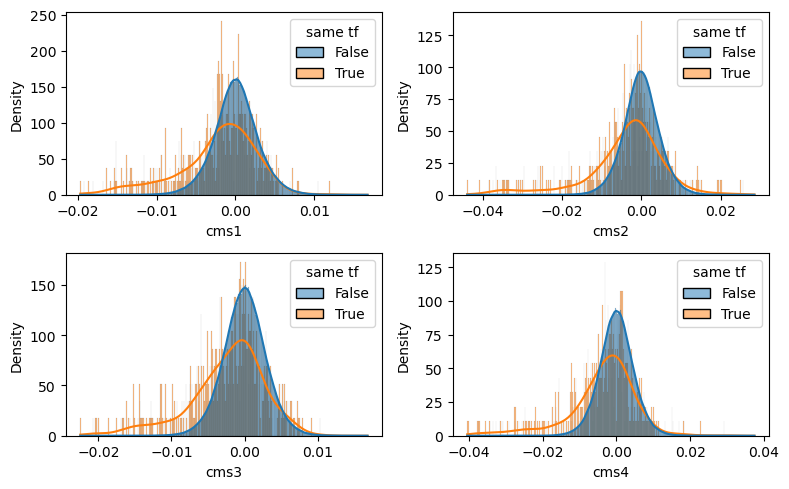

In [19]:
# Add binary label on whether the TFs are the same
dragon_trans['same tf'] = (dragon_trans.node1_tf == dragon_trans.node2_tf)

f, ax = plt.subplots(2,2, figsize = (8,5))
sns.histplot(x = 'cms1', data = dragon_trans, hue = 'same tf', stat = 'density', common_norm  = False, kde = True, ax = ax[0][0])
sns.histplot(x = 'cms2', data = dragon_trans, hue = 'same tf', stat = 'density', common_norm  = False, kde = True, ax = ax[0][1])
sns.histplot(x = 'cms3', data = dragon_trans, hue = 'same tf', stat = 'density', common_norm  = False, kde = True, ax = ax[1][0])
sns.histplot(x = 'cms4', data = dragon_trans, hue = 'same tf', stat = 'density', common_norm  = False, kde = True, ax = ax[1][1])
plt.tight_layout()
f.savefig(output_folder+'dragon_sametf_values.pdf')

Caption: 
Distribution of partial correlation values between methylation and expression of TFs in all subtypes. In orange
 we show the values for the edges of the same TF, that is the correlation between the methylation of the promoter and
 the expression of the that same TF. As expected, on average methylation and expression are negatively correlated.
 The histogram represents the distribution density and it is normalized per subtype and per group.

 #### Is the pattern the same?
We now check if the above edges are correlated between different subtypes


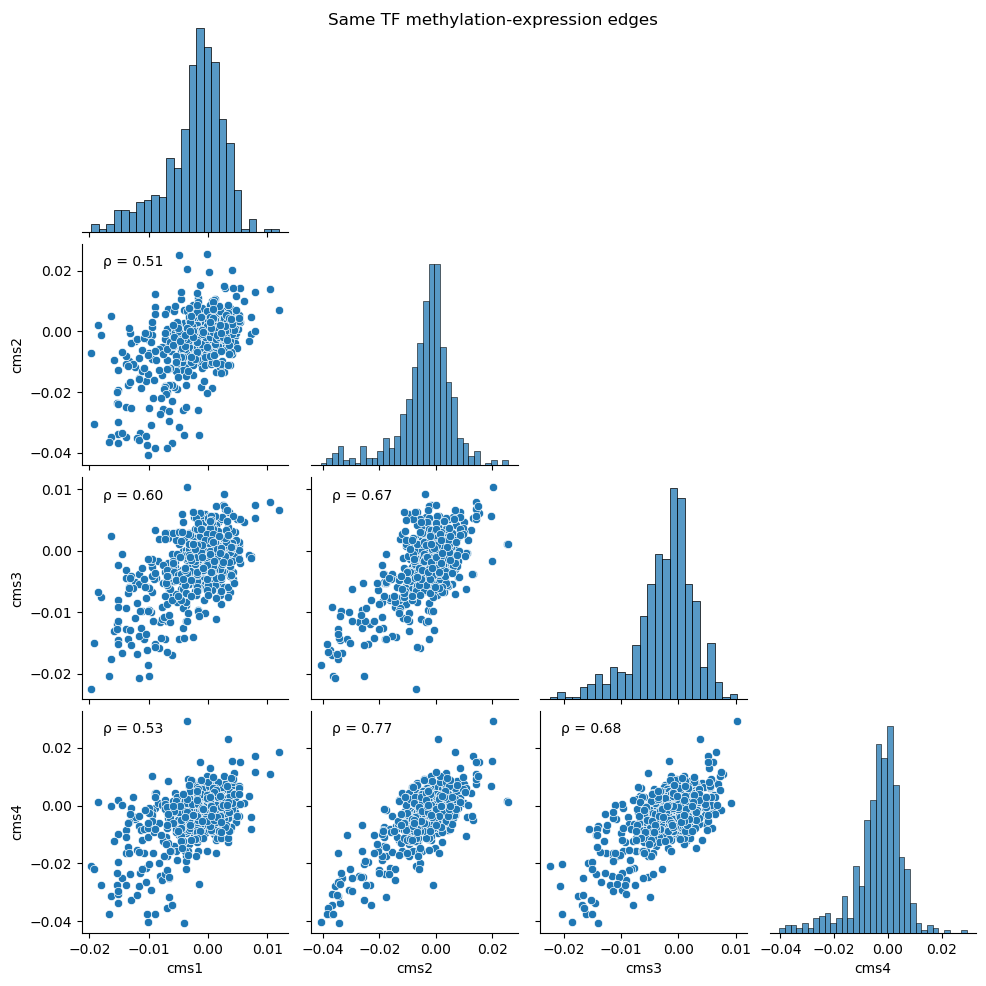

In [20]:
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt 

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
    
g = sns.pairplot(data = dragon_trans[dragon_trans['same']==1].loc[:,subtype_order].dropna(axis =0), corner = True)

g.map_lower(corrfunc)
g.fig.suptitle('Same TF methylation-expression edges')
g.fig.savefig(output_folder+'dragon_same_tf_edges.pdf')
plt.show()


## Clustering methylation to expression edges on different TFs


Instead of focusing on silencing, we look at more complex associations between different TFs. 


For inter-modality edges (methylation to expression), we remove the edges between the same transcription factor and we
look for patterns of similarity of the strongest edges between subtypes.

In [21]:
(dragon_trans.node1_type=='methylation').all(),(dragon_trans.node2_type=='expression').all()

(np.True_, np.True_)

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/4286086443.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_trans['abs_mean'] = dragon_trans.loc[:, [i+'_abs' for i in subtype_order]].mean(axis =1)
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/4286086443.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_trans['abs_var'] = dragon_trans.loc[:, [i+'_abs' for i in subtype_order]].var(axis =1)


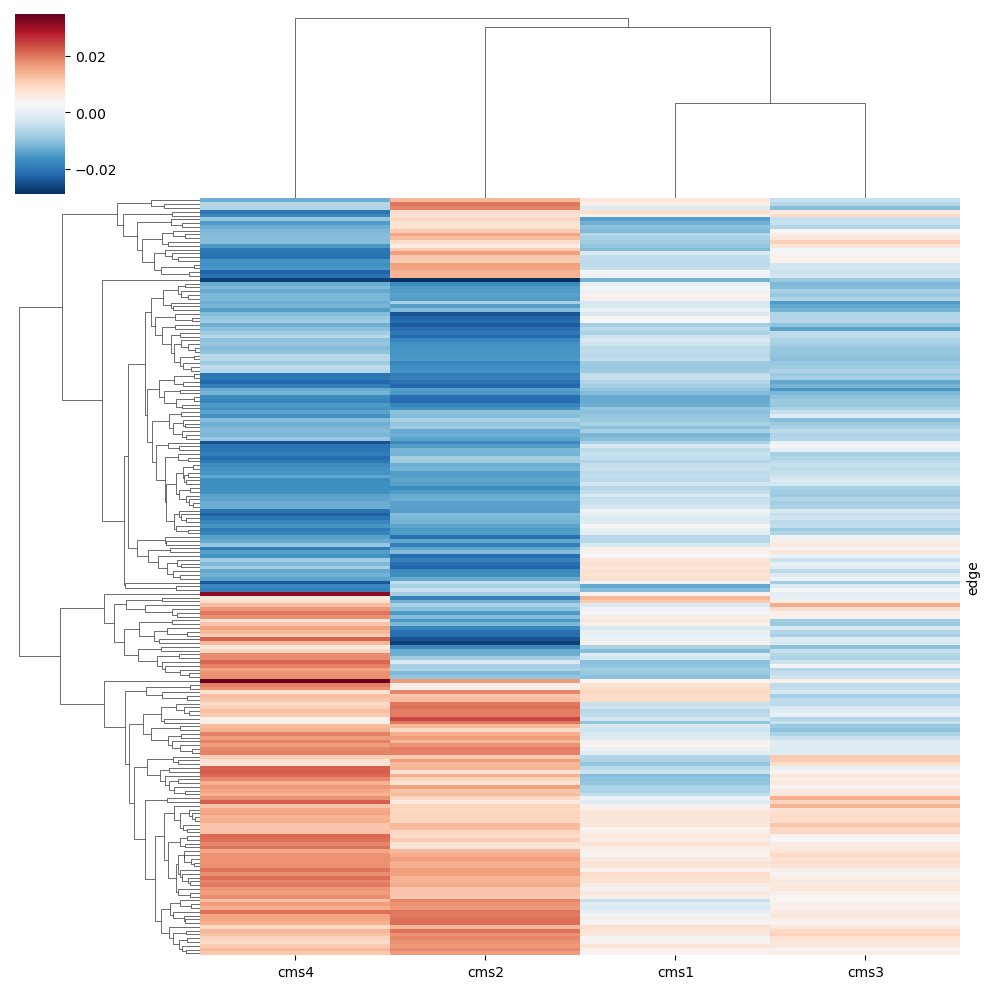

In [22]:
# top edges
K = 200 # this can be changed to include more or less edges, but you will see the cluster pattern to be similar
dragon_trans.loc[:, [i+'_abs' for i in subtype_order] ] = np.abs(dragon_trans.loc[:, subtype_order].values)
dragon_trans['abs_mean'] = dragon_trans.loc[:, [i+'_abs' for i in subtype_order]].mean(axis =1)
dragon_trans['abs_var'] = dragon_trans.loc[:, [i+'_abs' for i in subtype_order]].var(axis =1)

temp = dragon_trans[dragon_trans.node1_tf!=dragon_trans.node2_tf].dropna(subset= subtype_order, axis = 0).sort_values(by = 'abs_mean', ascending = False).iloc[:K,:].loc[:,subtype_order].fillna(0)
g1 = sns.clustermap(temp, cmap = 'RdBu_r', yticklabels = False)

Since we can distinctly recognize clusters of edges that are different between CMS2 and CMS4 we proceed to actually
cluster the data.

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/2319495232.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma', len(temp['cluster'].unique()))


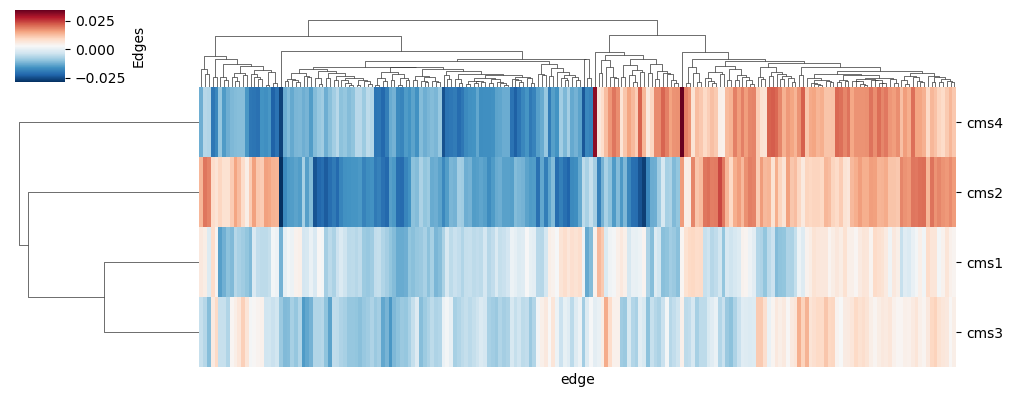

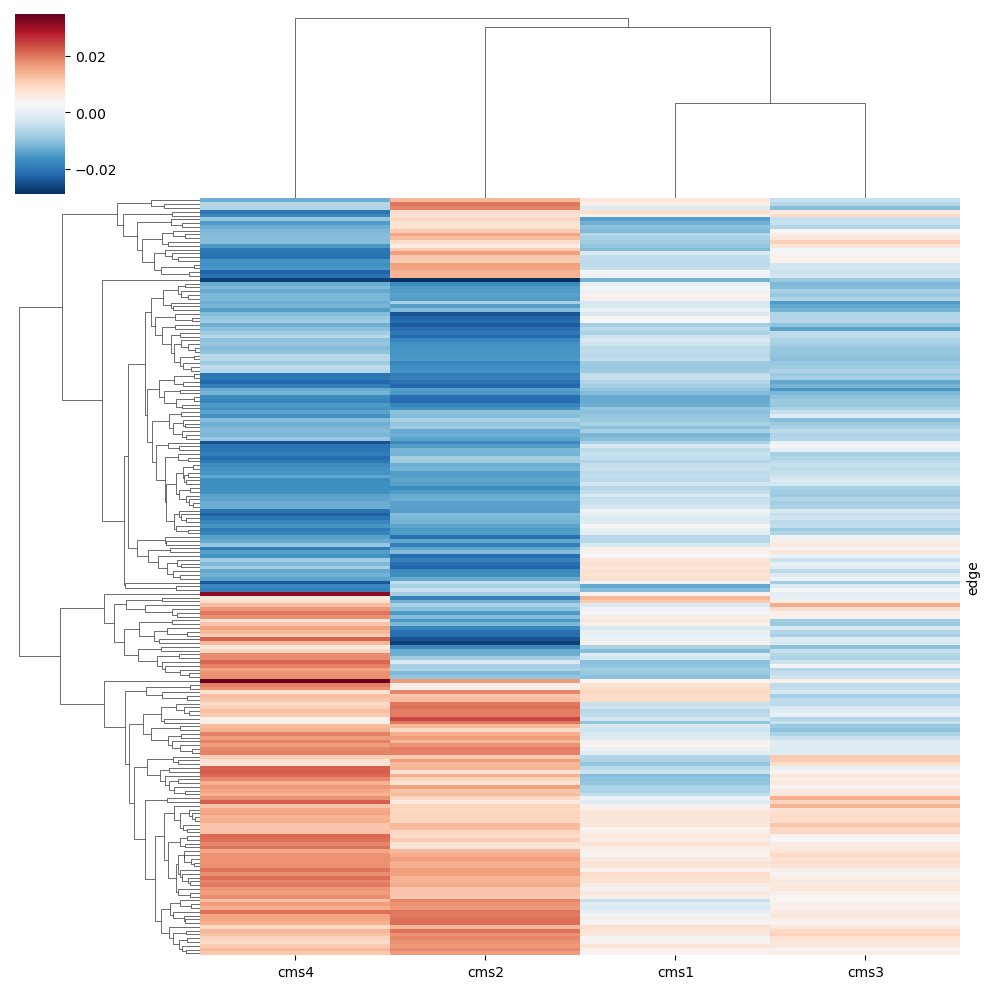

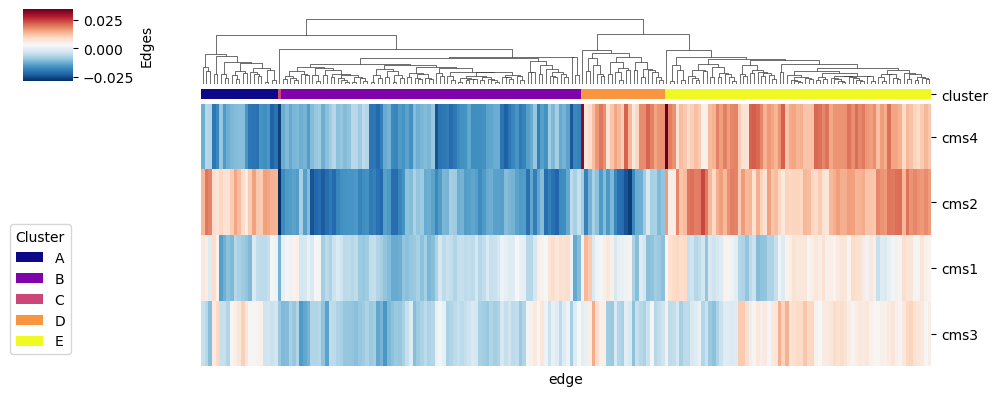

In [23]:
import scipy
import matplotlib
from matplotlib import cm as cm

temp = dragon_trans[dragon_trans.node1_tf!=dragon_trans.node2_tf].dropna(subset= subtype_order, axis = 0).sort_values(by = 'abs_mean', ascending = False).iloc[:K,:].loc[:,subtype_order].fillna(0)

g0 = sns.clustermap(temp.T, xticklabels = False,cmap = 'RdBu_r', cbar_kws={'label': 'Edges'}, yticklabels = True, figsize = (10,4))
# rotate the yticklabels of clustermap g1
g0.ax_heatmap.set_yticklabels(g0.ax_heatmap.get_yticklabels(), rotation=0)
g0.fig.savefig(output_folder+'all_cms_dragon_heatmap.pdf')

g1 = sns.clustermap(temp, cmap = 'RdBu_r', yticklabels = False)

temp['cluster_number'] = scipy.cluster.hierarchy.fcluster(g1.dendrogram_row.linkage, t = 5, criterion = 'maxclust')
# transform number to letter sequentially like a,B,C
temp['cluster'] = [chr(i+65) for i in temp['cluster_number']-1]

cmap = cm.get_cmap('plasma', len(temp['cluster'].unique()))
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
lut = dict(zip(sorted(temp['cluster'].unique()), color_list))
row_colors = temp['cluster'].map(lut)
# change aspect to clustermap
g1 = sns.clustermap(temp.loc[:,subtype_order].T, col_colors=row_colors, xticklabels = False, 
               cmap = 'RdBu_r', cbar_kws={'label': 'Edges'}, yticklabels = True,
               figsize = (10,4))

# rotate the yticklabels of clustermap g1
g1.ax_heatmap.set_yticklabels(g1.ax_heatmap.get_yticklabels(), rotation=0)

from matplotlib.patches import Patch

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Cluster',
           bbox_to_anchor=(0, 0.1), bbox_transform=plt.gcf().transFigure, loc='lower left')

# remove row dendrogram
g1.ax_row_dendrogram.set_visible(False)
g1.fig.savefig(output_folder+'all_cms_dragon_clustermap.pdf')


**Caption**: For
 inter-modality edges (methylation to expression), we remove the edges between the same transcription factor, and we
 select the first 200 strongest edges (highest average absolute value of correlation) and we cluster them by correlation values for each subtype. Interestingly, for cluster A and
 D the edge values for CMS2 and CMS4 are swapped in direction.


## Analysis and visualization of the different clusters

Now we dig deeper in the TFs that are in the clusters and the subgraph they draw.

In [24]:
temp

cms1      cms2      cms3      cms4  cluster_number cluster
edge                                                                          
ZNF345-ZNF790  -0.012222 -0.028967 -0.009026 -0.026827               3       C
HOXB5-HOXB6    -0.006764 -0.020931 -0.013662 -0.022181               2       B
HOXB8-HOXB6    -0.013081 -0.021357 -0.010234 -0.017450               2       B
HOXB8-HOXB5    -0.013158 -0.021508 -0.009058 -0.018268               2       B
HOXB5-HOXB4    -0.008069 -0.022063 -0.012032 -0.019201               2       B
...                  ...       ...       ...       ...             ...     ...
STAT5A-PPARG    0.000949 -0.014860 -0.007660 -0.013302               2       B
ZNF280D-ZNF513 -0.003187 -0.008399 -0.007266  0.017902               4       D
DOT1L-EVX1      0.004228 -0.010934  0.006868 -0.014698               2       B
MYOG-NFE2L3     0.004753 -0.011374 -0.008851  0.011738               4       D
THAP3-ZNF513   -0.001000 -0.012193 -0.005502 -0.018000               2       B

[200 rows x 6 columns]

In [25]:
# We retrieve the clusters
clusts = {}
for i,tab in temp.groupby('cluster'):
    print(i, len(tab))
    meth = [i.split('-')[0] for i in tab.index]
    expr = [i.split('-')[1] for i in tab.index]
    all = meth+expr
    clusts[i] = {}
    clusts[i]['all'] = all
    clusts[i]['meth'] = meth
    clusts[i]['expr'] = expr

A 21
B 82
C 1
D 23
E 73


Now we show the distribution of the edge values for all the TFs in each cluster. We also want to check the general
distribution of the edges, to control that the differences between CMS2 and CMS4 are "interesting" and not just an
overall effect. 

Given the nodes in the heterogeneous edges (M-E) for each cluster $c$, with methylation nodes $m \in M_c$ and expression nodes $e \in E_c$,
we keep all edges between $M_c$ and $E_c$, and select as "of interest" (oi label) those that exactly belong to cluster
$c$. 

Example: if cluster $c$ is made of oi = {M1-E2, M2-E4, M3-E2} we will also keep the edges (M1-E2, M1-E4, M2-E2, M2-E2,
M3-E2, M3-E4) 

This way we have a way to compare the other edges between these TFs.

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1055373860.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1055373860.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1055373860.py:12: FutureWarning: 

(21, 20)
(57, 20)


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1055373860.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1055373860.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1055373860.py:12: FutureWarning: 

(82, 20)
(115, 20)


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1055373860.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1055373860.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1055373860.py:12: FutureWarning: 

(1, 20)
(3, 20)


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1055373860.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1055373860.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1055373860.py:12: FutureWarning: 

(23, 20)
(63, 20)


/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1055373860.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1055373860.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/1055373860.py:12: FutureWarning: 

(73, 20)
(111, 20)


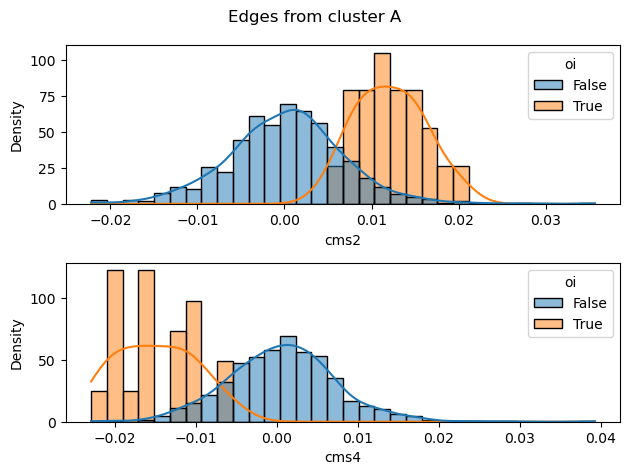

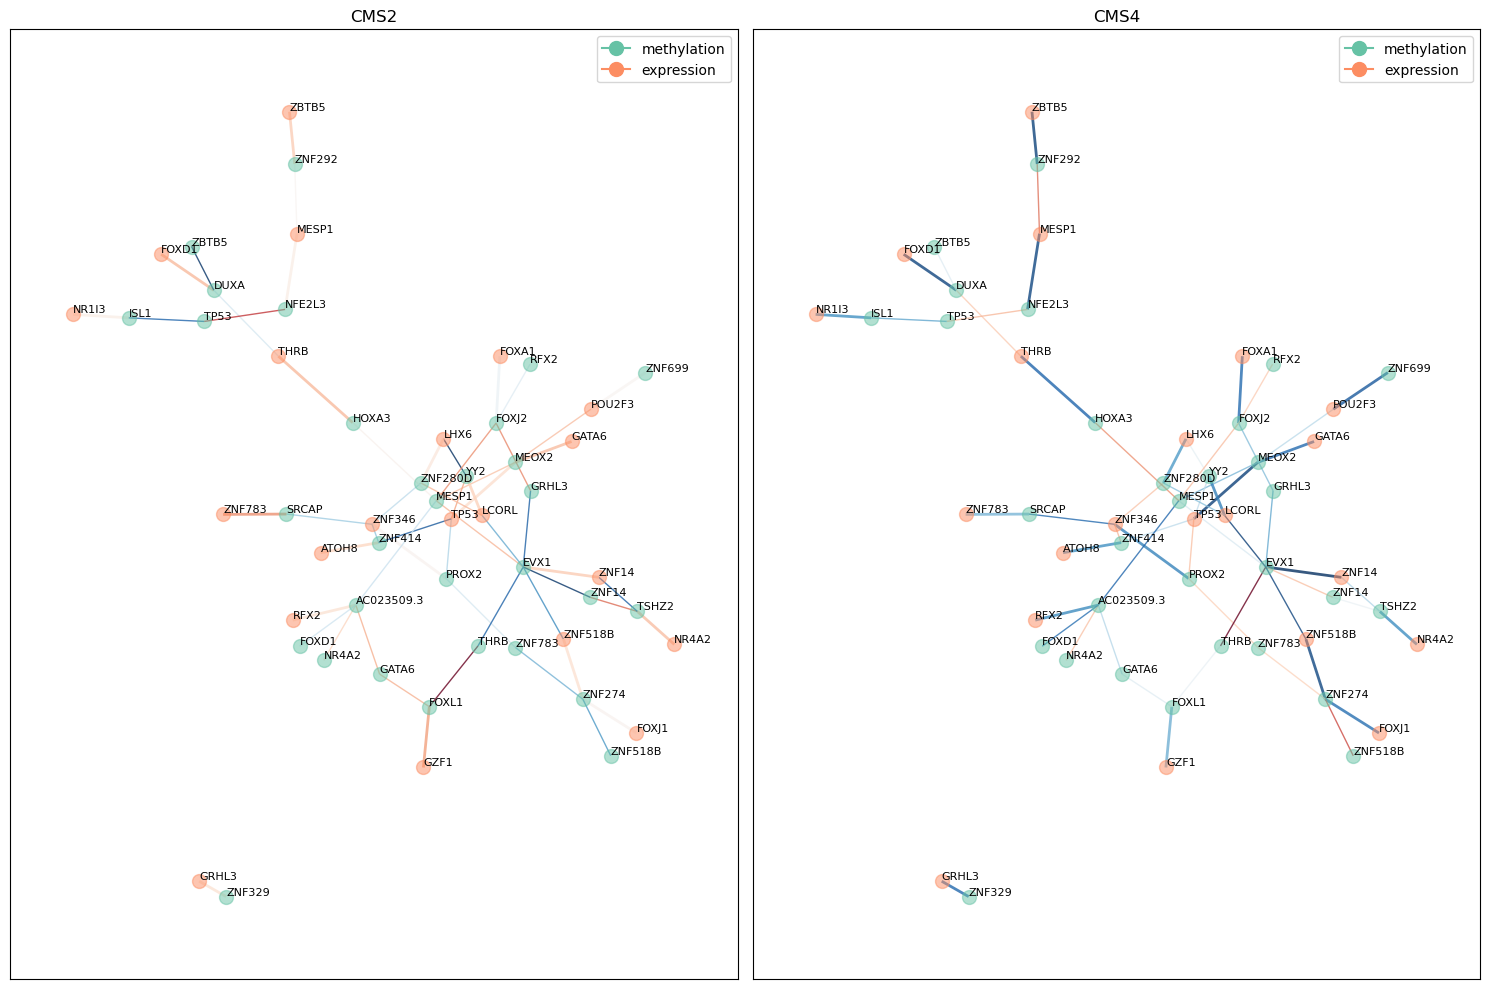

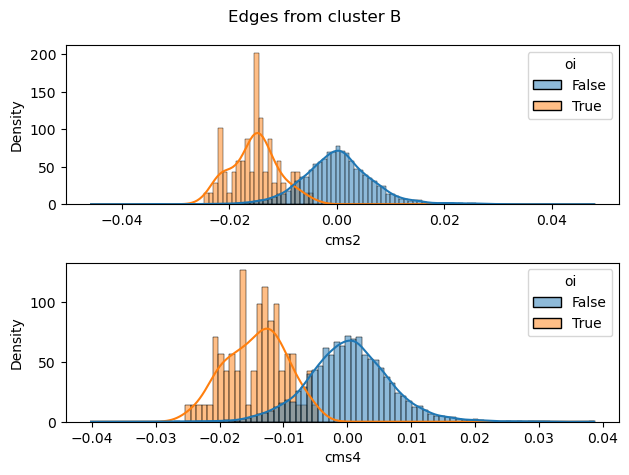

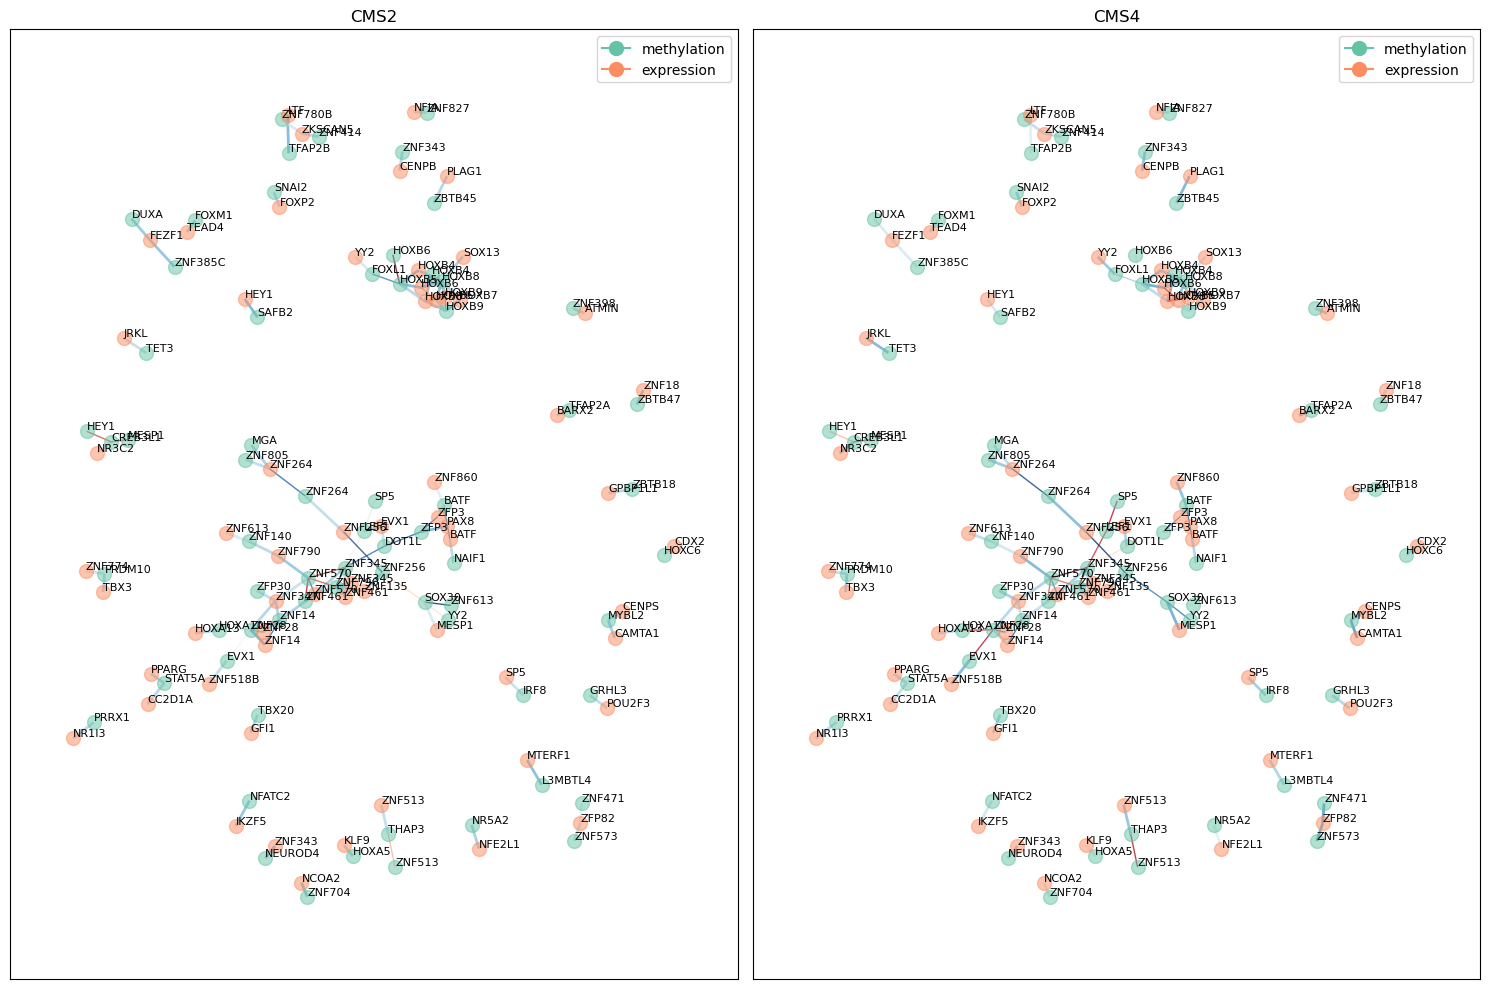

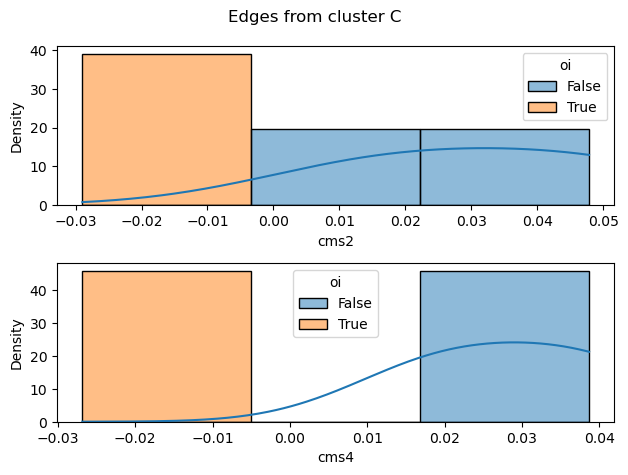

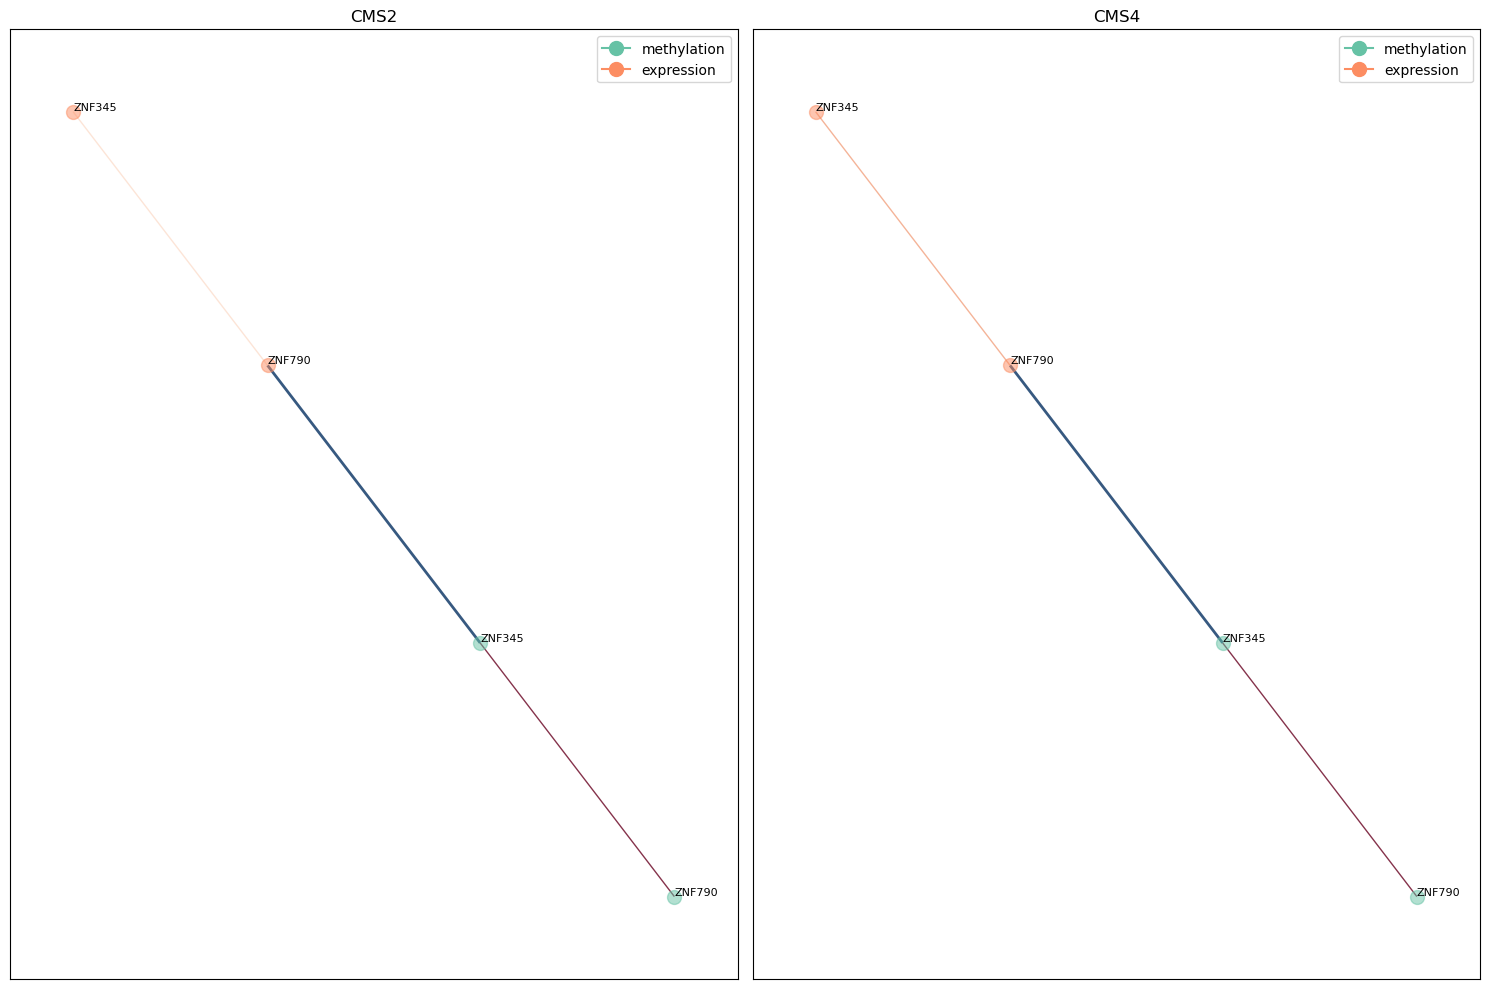

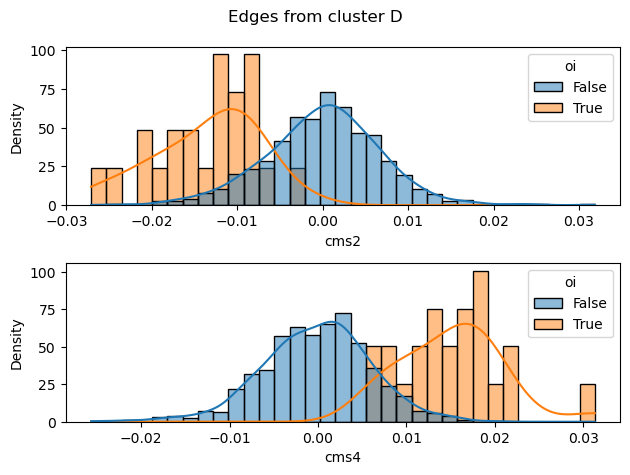

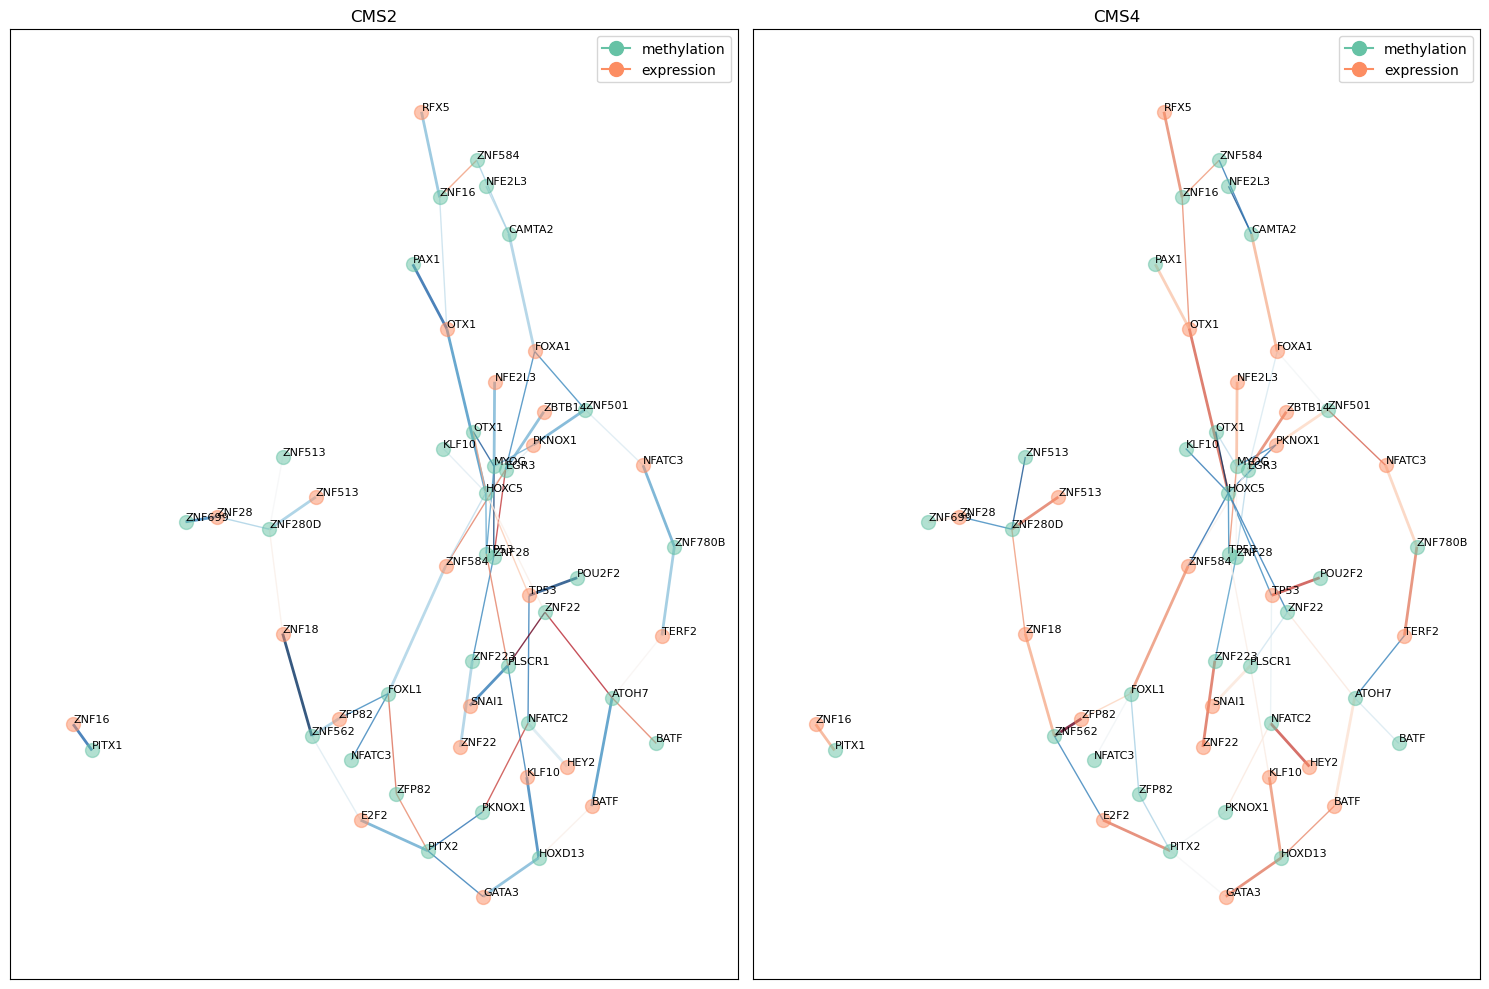

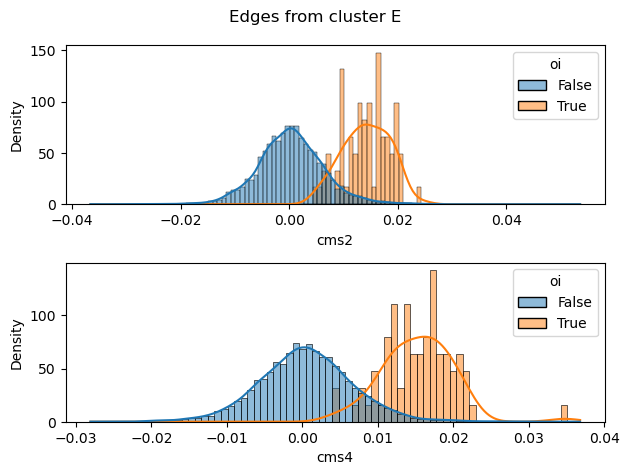

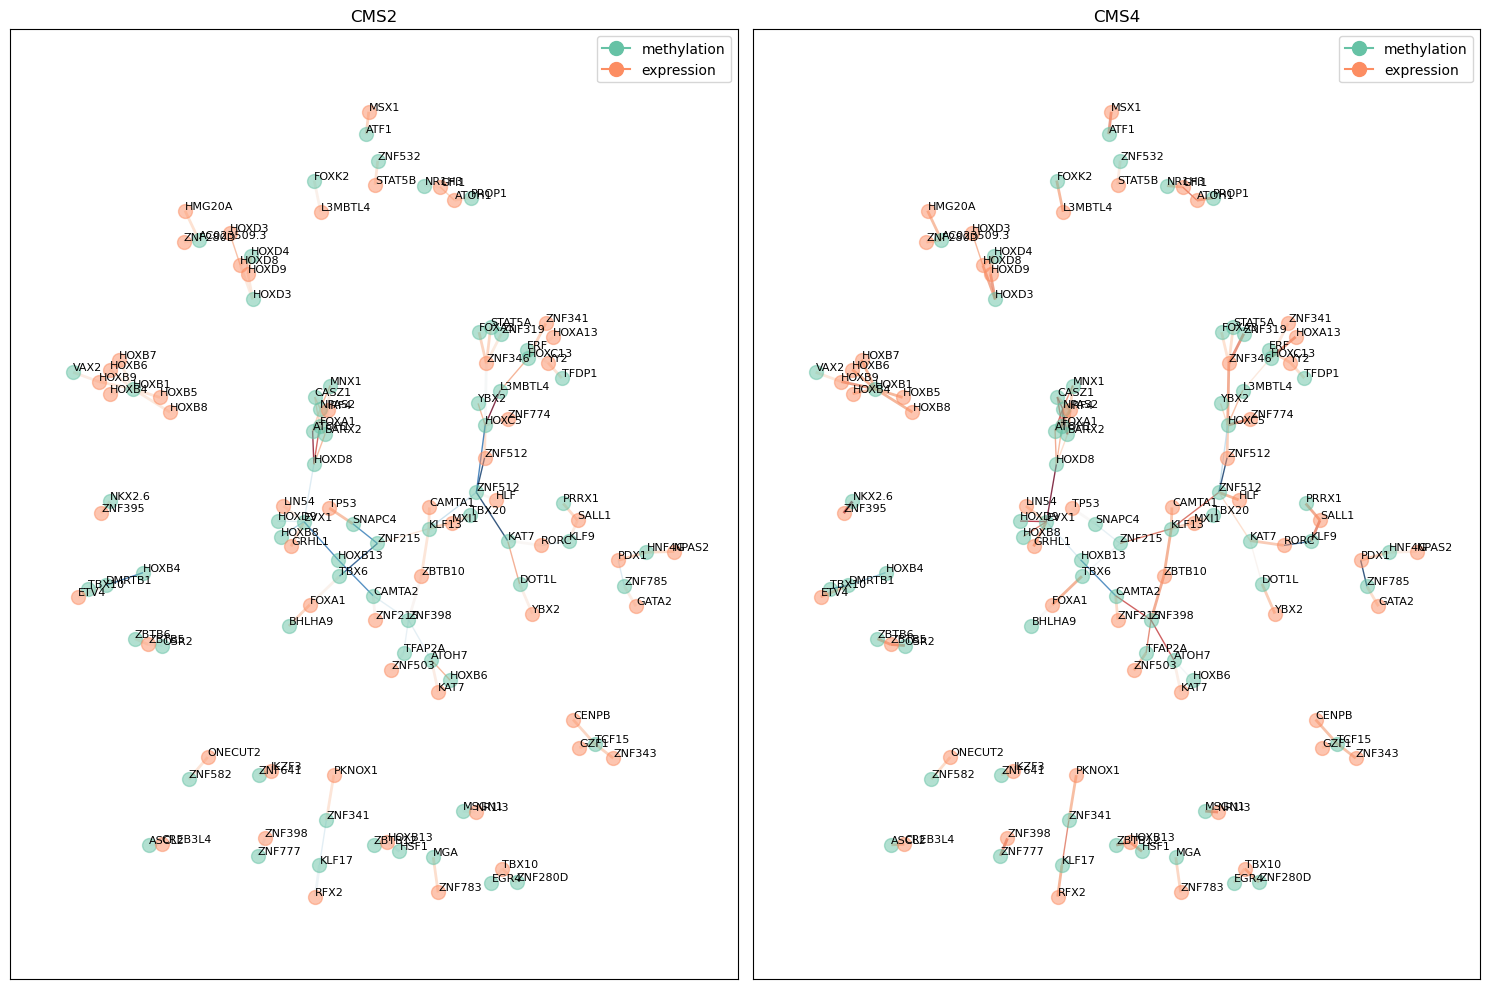

In [26]:
for k in clusts.keys():
    # We get the table with the edges of interest and the edges from the same nodes
    tf1 = [i.split('-')[0] for i in temp[temp['cluster']==k].index]
    tf2 = [i.split('-')[1] for i in temp[temp['cluster']==k].index]
    tf1_meth = [i.split('-')[0]+'_methylation' for i in temp[temp['cluster']==k].index]
    tf2_expr = [i.split('-')[1]+'_expression' for i in temp[temp['cluster']==k].index]
    
    complete_edges = [tf1_meth[i] +'-'+ tf2_expr[i] for i in range(len(tf1_meth))]

    dragon_oi = dragon[(dragon['node1_tf'].isin(tf1)) & (dragon['node2_tf'].isin(tf2)) ]
    dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
    dragon_oi['tf_edge'] = [dragon_oi.node1_tf[i] +'-'+ dragon_oi.node2_tf[i] for i in range(len(dragon_oi))]


    dragon_oi['oi'] = dragon_oi['complete_edge'].isin(complete_edges)
    dragon_oi = dragon_oi.set_index('complete_edge').sort_values(by = 'oi')
    
    # We save the table with the edges for each cluster (both those in the actual luster and those from the same tfs)
    dragon_oi.to_csv(output_folder + 'all_cms_dragon_clust%s.csv' %k)
    
    # Figure of edge of interest distribution
    f, ax = plt.subplots(2, 1)
    sns.histplot(x = 'cms2', hue = 'oi',data = dragon_oi, common_norm=False, kde = True, stat = 'density', ax = ax[0])
    sns.histplot(x = 'cms4', hue = 'oi',data = dragon_oi, common_norm=False, kde = True, stat = 'density', ax = ax[1])
    f.suptitle('Edges from cluster %s' %k)
    plt.tight_layout()
    f.savefig(output_folder + 'all_cms_edge_distribution_clust%s.pdf' %k)
    
    # Now we plot the graph
    # Get the graph
    graph_oi = dragon_oi[dragon_oi['oi']]
    dragonother = dragon_oi[~dragon_oi['oi']]
    # This would filter by edge values
    #dragon_graph = dragonother[(dragonother.cms2_abs>0.015) | (dragonother.cms4_abs>0.015)]
    
    # We filter the top edges
    K = 20
    dragon_other1 = dragonother.sort_values(by = 'cms2_abs', ascending = False).iloc[:K, :]
    dragon_other2 = dragonother.sort_values(by = 'cms4_abs', ascending = False).iloc[:K, :]
    dragon_graph = pd.concat([graph_oi, dragon_other1, dragon_other2], axis = 0).drop_duplicates()
    print(graph_oi.shape)
    print(dragon_graph.shape)
    
    
    
    import networkx as nx
    dragon_graph['edge_label_oi'] = ['*' if i==True else "" for i in dragon_graph['oi']]
    dragon_graph['edge_label_width'] = [2 if i==True else 1 for i in dragon_graph['oi']]
    G = nx.from_pandas_edgelist(dragon_graph, source = 'node1', target = 'node2', edge_attr = ['cms2', 'cms2_abs','cms4', 'cms4_abs', 'oi', 'edge_label_oi', 'edge_label_width'])
    

    draw_both_graphs(G, output_folder + 'all_cms_graph_cluster%s.pdf' %k)

    
    

#### We draw cluster D again, for better visualization

you can skip the following two cells, these are only made to reproduce the graph figure in the paper. It just cleans the
visualization compared to the grahs above.

In [27]:
for k in ['D']:
    # We get the table with the edges of interest and the edges from the same nodes
    tf1 = [i.split('-')[0] for i in temp[temp['cluster']==k].index]
    tf2 = [i.split('-')[1] for i in temp[temp['cluster']==k].index]
    tf1_meth = [i.split('-')[0]+'_methylation' for i in temp[temp['cluster']==k].index]
    tf2_expr = [i.split('-')[1]+'_expression' for i in temp[temp['cluster']==k].index]
    complete_edges = [tf1_meth[i] +'-'+ tf2_expr[i] for i in range(len(tf1_meth))]

    dragon_oi = dragon[(dragon['node1_tf'].isin(tf1)) & (dragon['node2_tf'].isin(tf2)) ]
    dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]

    dragon_oi['oi'] = dragon_oi['complete_edge'].isin(complete_edges)
    dragon_oi = dragon_oi.set_index('complete_edge').sort_values(by = 'oi')
    
    
    # Now we plot the graph
    
    # Get the graph
    graph_oi = dragon_oi[dragon_oi['oi']]
    dragonother = dragon_oi[~dragon_oi['oi']]
    # This would filter by edge values
    #dragon_graph = dragonother[(dragonother.cms2_abs>0.015) | (dragonother.cms4_abs>0.015)]
    # We filter the top edges
    K = 20
    dragon_other1 = dragonother.sort_values(by = 'cms2_abs', ascending = False).iloc[:K, :]
    dragon_other2 = dragonother.sort_values(by = 'cms4_abs', ascending = False).iloc[:K, :]
    dragon_graph = pd.concat([graph_oi, dragon_other1, dragon_other2], axis = 0).drop_duplicates()
    
    
    import networkx as nx
    dragon_graph['edge_label_oi'] = ['*' if i==True else "" for i in dragon_graph['oi']]
    dragon_graph['edge_label_width'] = [3 if i==True else 1 for i in dragon_graph['oi']]
    G = nx.from_pandas_edgelist(dragon_graph, source = 'node1', target = 'node2', edge_attr = ['cms2', 'cms2_abs','cms4', 'cms4_abs', 'oi', 'edge_label_oi', 'edge_label_width'])
    

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/2300356542.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/2300356542.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_oi['complete_edge'] = [dragon_oi.node1[i] +'-'+ dragon_oi.node2[i] for i in range(len(dragon_oi))]
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/2300356542.py:12: SettingWithCopy

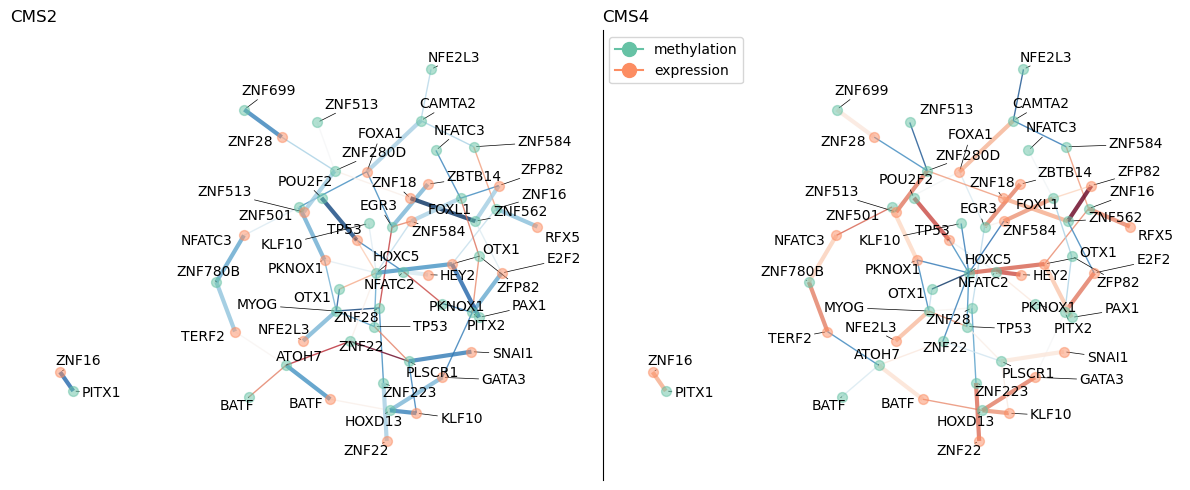

In [28]:

from adjustText import adjust_text
def draw_graphs_clusterd(G, fig_name):
    """Draw both graphs for CMS2 and CMS4"""
    
    pos = nx.spring_layout(G, seed=100, iterations=32,k=1/np.sqrt(G.order()))  # positions for all nodes
    #pos = nx.spectral_layout(G, scale=.1, center=None, dim=2)
    weights2 = nx.get_edge_attributes(G,'cms2').values()
    weights4 = nx.get_edge_attributes(G,'cms4').values()
    edge_labels = nx.get_edge_attributes(G,'edge_label_oi').values()
    edge_width = list(nx.get_edge_attributes(G,'edge_label_width').values())

    f,ax = plt.subplots(1,2,figsize = (12,5))
    options_node = {"node_size": 50, "alpha": 0.5}

    node_meth = [i  for i in list(G.nodes) if i.endswith('methylation') ]
    node_expr = [i  for i in list(G.nodes) if i.endswith('expression') ]

    # Methylation and expression nodes for CMS2
    nx.draw_networkx_nodes(G, pos, nodelist=node_meth, node_color="#66c2a5", **options_node, ax = ax[0])#, edgecolors='k')
    nx.draw_networkx_nodes(G, pos, nodelist=node_expr, node_color="#fc8d62", **options_node, ax = ax[0])#, edgecolors='k')

    # Node labels for methylation
    #nx.draw_networkx_labels(G, pos, {node_meth[k]:node_meth[k].split('_')[0] for k in range(len(node_meth))}, font_size=8, ax = ax[0], verticalalignment='bottom', horizontalalignment='left')
    #nx.draw_networkx_labels(G, pos, {node_meth[k]:node_meth[k].split('_')[0] for k in range(len(node_meth))}, font_size=8, ax = ax[1], verticalalignment='bottom', horizontalalignment='left')

    # Node labels for expression
    #nx.draw_networkx_labels(G, pos, {node_expr[k]:node_expr[k].split('_')[0] for k in range(len(node_expr))}, font_size=8, ax = ax[0], verticalalignment='bottom', horizontalalignment='left')
    #nx.draw_networkx_labels(G, pos, {node_expr[k]:node_expr[k].split('_')[0] for k in range(len(node_expr))}, font_size=8, ax = ax[1], verticalalignment='bottom', horizontalalignment='left')

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights2)], edge_cmap=plt.cm.RdBu_r,  ax = ax[0], width = edge_width)

    #nx.draw_networkx_edge_labels(G, pos, edge_labels = nx.get_edge_attributes(G,'edge_label_oi'), ax = ax[0],  bbox={'facecolor':'white', 'edgecolor':'none', 'pad':0})
    #nx.draw_networkx_edge_labels(G, pos, edge_labels = nx.get_edge_attributes(G,'edge_label_oi'), ax = ax[1],  bbox={'facecolor':'white', 'edgecolor':'none', 'pad':0})

    #nx.draw_networkx_labels(G_cms2, pos, {list(G_cms2.nodes)[k]:list(G_cms2.nodes)[k].split('_')[0] for k in range(len(G_cms2.nodes))}, font_size=9)


    meth_node = Line2D([0], [0], marker='o', color='#66c2a5', label='methylation',
                            markersize=10)
    expr_node = Line2D([0], [0], marker='o', color='#fc8d62', label='expression',
                            markersize=10)

    #ax[0].legend(handles=[meth_node, expr_node])
    ax[0].set_title('CMS2', loc = 'left')
    
    # Draw node labels separately
    labels = {node: node for node in G.nodes()}
    texts = []
    for node, (x, y) in pos.items():
        nodename = node.split('_')[0]
        texts.append(ax[0].text(x, y, str(nodename), fontsize=10, ha='center', va='center'))

    # Adjust the text labels to prevent overlap
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), ax = ax[0])
    #f.savefig(fig_name)
    
    # Methylation and expression nodes for CMS4
    nx.draw_networkx_nodes(G, pos, nodelist=node_meth, node_color="#66c2a5", **options_node, ax = ax[1])#, edgecolors='k')
    nx.draw_networkx_nodes(G, pos, nodelist=node_expr, node_color="#fc8d62", **options_node, ax = ax[1])#, edgecolors='k')
    
    nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color=[50*i for i in list(weights4)], edge_cmap=plt.cm.RdBu_r, ax = ax[1], width = edge_width)
    
    ax[1].legend(handles=[meth_node, expr_node])
    
    # Draw node labels separately
    labels = {node: node for node in G.nodes()}
    texts2 = []
    for node, (x, y) in pos.items():
        nodename = node.split('_')[0]
        texts2.append(ax[1].text(x, y, str(nodename), fontsize=10, ha='center', va='center'))

    # Adjust the text labels to prevent overlap
    adjust_text(texts2, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), ax = ax[1])
    ax[1].set_title('CMS4', loc = 'left')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    #remove the box around the axis
    #ax[0].axis('off')
    #ax[1].axis('off')
    for i in range(2):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    # add only one vertical line to the axis
    #ax[0].axvline(1.1, color='k', linestyle='--')
    plt.tight_layout()
    
    f.savefig(fig_name)

draw_graphs_clusterd(G, output_folder + 'all_cms_clean_graph_clusterD.pdf')

## Pathways for each cluster

For each cluster we do a pathway analysis with REACTOME. 

From the [REACTOME database](https://reactome.org/) we have downloaded the tables that map each gene identifier to a
pathway, and that also map each pathway to the parent terms. For instance "Intracellular signaling by second
messengers", "Signaling by GPCR", "Signaling by Hedgehog"...
are all part of the "Signaling Transduction" term.

In the `reactome_child_ancestor.csv` file we have linked each term to the most general term in REACTOME. 

Then, to reduce the number of tested pathways, which also reduces overlaps between pathways, we have generated a "slim"
set of pathways. For each leaf in the reactome dataset, we have kept only the "parent" node. This way we avoid keeping
all the nodes that are too small, and we keep only the `depth-1` term.

The pathways are in the `hugo_reactome_slim.gmt` and we have kept the reactome ID. 

**WARNING** 
Here we are using the gseapy package that can also be used without our own REACTOME pathway files.


In [31]:
reactome_hierarchy_fn = '../data/external/reactome_slim/reactome_child_ancestor.csv'
reactome_gmt_fn ='../data/external/reactome_slim/hugo_reactome_slim.gmt'


It is important to point out that we need to select the correct background for the over representation analysis. 

In [32]:
hierarchy = pd.read_csv(reactome_hierarchy_fn)

import gseapy as gp
bckg = set(dragon.node1_tf).union(set(dragon.node2_tf))
bckg_meth = set(dragon.node1_tf)
bckg_expr = set(dragon.node2_tf)
res_all = {}
res_expr = {}
res_meth = {}
for key, items in clusts.items():
    if len(items['all'])>10:
        res_all[key] = gp.enrich(gene_list=items['all'], gene_sets=reactome_gmt_fn, background = bckg)
        res_expr[key] = gp.enrich(gene_list=items['expr'], gene_sets=reactome_gmt_fn, background = bckg_expr)
        res_meth[key] = gp.enrich(gene_list=items['meth'], gene_sets=reactome_gmt_fn, background = bckg_meth)
        
        res_all[key].res2d.to_csv(output_folder+'all_cms_enrich_all_clust%s.tsv' %key, sep = '\t')
        res_expr[key].res2d.to_csv(output_folder+'all_cms_enrich_expr_clust%s.tsv' %key, sep = '\t')
        res_meth[key].res2d.to_csv(output_folder+'all_cms_enrich_meth_clust%s.tsv' %key, sep = '\t')

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/3046001452.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set3', len(column.unique()))
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/3046001452.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set3', len(column.unique()))
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/3046001452.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_c

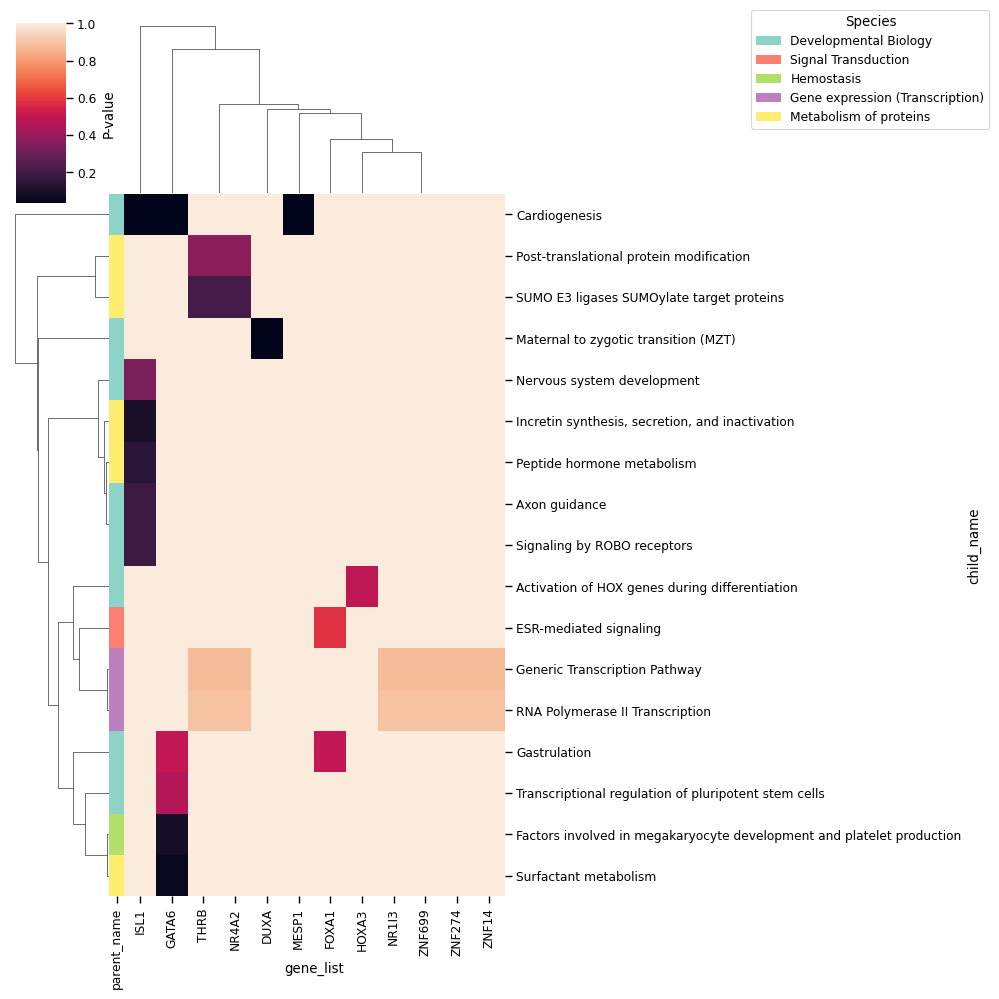

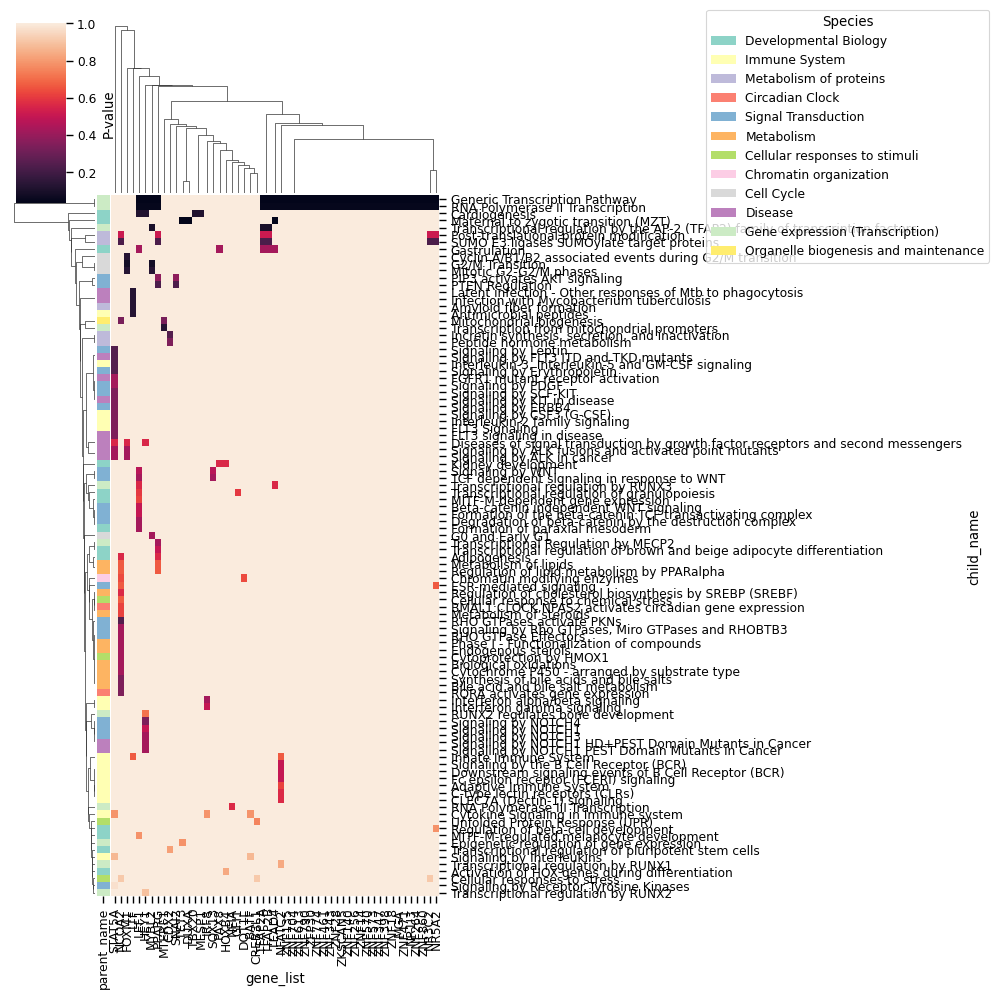

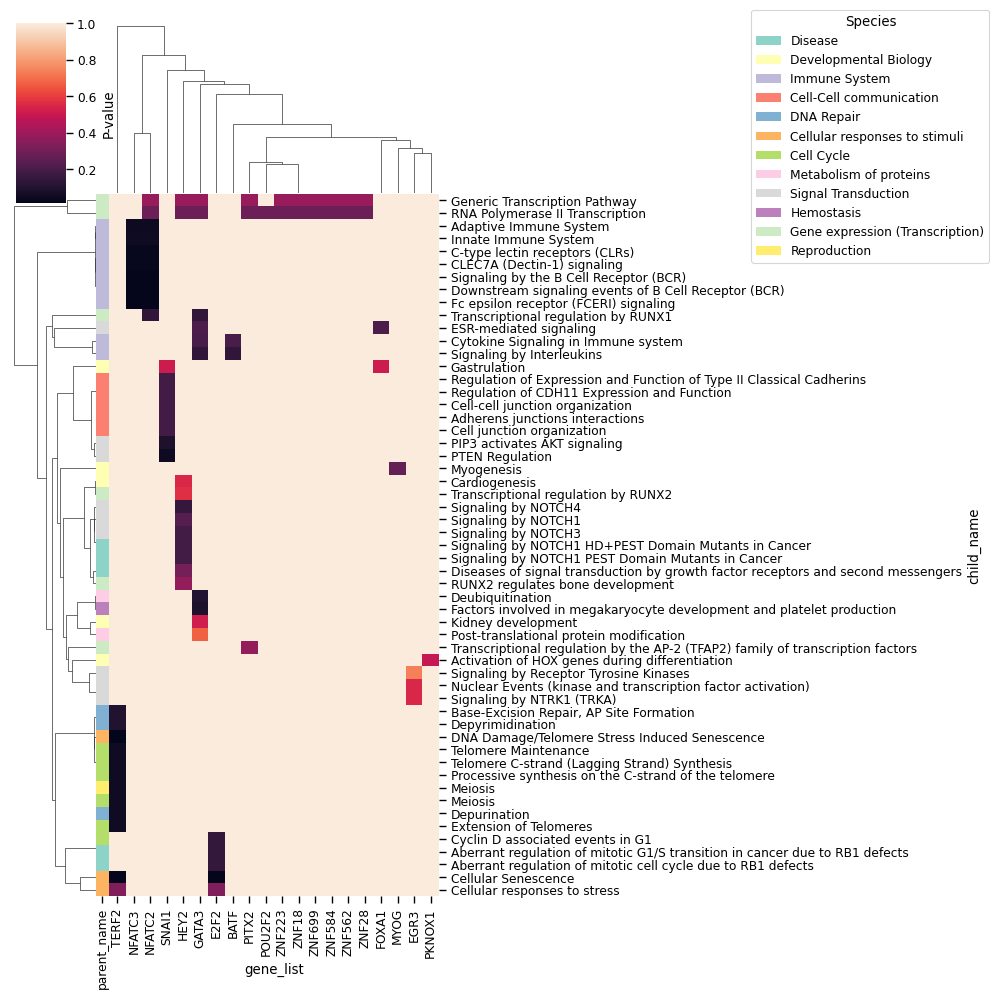

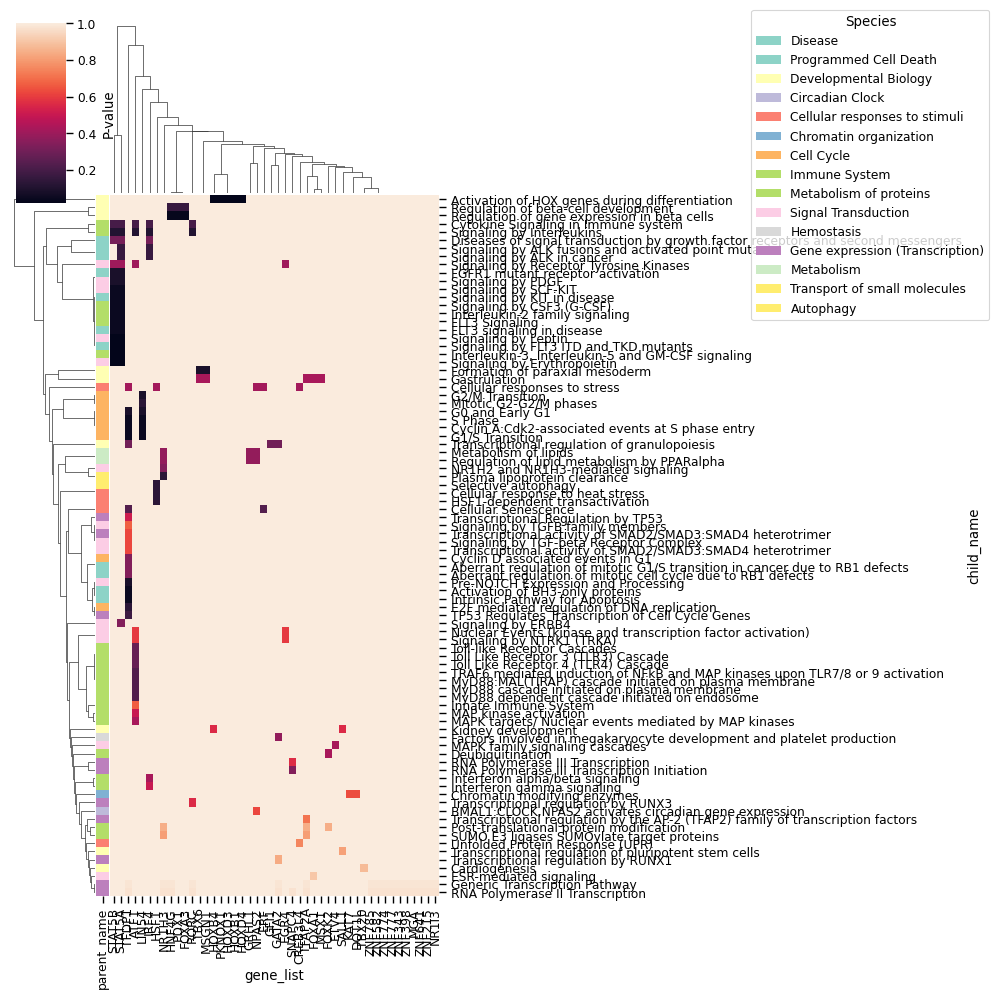

In [33]:
for key, items in res_all.items():
    res_all[key].res2d['gene_list'] = [i.split(';') for i in res_all[key].res2d.Genes]
    res_all
    mytab = pd.pivot_table(res_all[key].res2d.explode('gene_list'), index = 'Term', columns= 'gene_list', values='P-value')
    notp53 = list(set(mytab.columns.tolist()).difference(set(['TP53'])))
    mytab = mytab.loc[:,notp53].dropna(axis = 0,how = 'all').fillna(1)

    mytab_genes = mytab.columns
    mytab_full = mytab.merge(hierarchy, left_index=True, right_on = 'child_name').set_index('child_name')

    column = mytab_full['parent_name']
    cmap = cm.get_cmap('Set3', len(column.unique()))
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    lut = dict(zip(column.unique(), color_list))
    row_colors = column.map(lut)
    sns.set_context('paper')



    g1 = sns.clustermap(mytab_full.loc[:,mytab_genes], row_colors=row_colors, yticklabels = 1, xticklabels = 1, cbar_kws={'label': 'P-value'})
    plt.setp(g1.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)


    from matplotlib.patches import Patch

    handles = [Patch(facecolor=lut[name]) for name in lut]
    plt.legend(handles, lut, title='Species',
            bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

    g1.fig.savefig(output_folder+'all_cms_pathway_tfs_all_clustermap_cluster%s.pdf' %key, bbox_inches = 'tight')

Now we do the same plot but cleaner. We keep only the parent annotation. 

A
                 Gene_set                                            Term  \
0  hugo_reactome_slim.gmt                 Activation of BH3-only proteins   
1  hugo_reactome_slim.gmt  Activation of HOX genes during differentiation   
2  hugo_reactome_slim.gmt     Antiviral mechanism by IFN-stimulated genes   
3  hugo_reactome_slim.gmt                                   Axon guidance   
4  hugo_reactome_slim.gmt                                   Cardiogenesis   

  Overlap   P-value  Adjusted P-value  Odds Ratio  Combined Score  \
0     1/3  0.141784          0.354460   11.612658       22.684751   
1    1/13  0.486666          0.575150    2.292152        1.650757   
2     1/4  0.184535          0.374836    8.283906       13.999128   
3     1/4  0.184535          0.374836    8.283906       13.999128   
4    3/15  0.034024          0.293255    5.633600       19.045471   

              Genes             gene_list  
0              TP53                [TP53]  
1             HOXA3             

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/898555803.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set3', len(column.unique()))
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/898555803.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set3', len(column.unique()))


D
                 Gene_set                                               Term  \
0  hugo_reactome_slim.gmt  Aberrant regulation of mitotic G1/S transition...   
1  hugo_reactome_slim.gmt  Aberrant regulation of mitotic cell cycle due ...   
2  hugo_reactome_slim.gmt                    Activation of BH3-only proteins   
3  hugo_reactome_slim.gmt     Activation of HOX genes during differentiation   
4  hugo_reactome_slim.gmt                             Adaptive Immune System   

  Overlap   P-value  Adjusted P-value  Odds Ratio  Combined Score  \
0     1/3  0.145145          0.290290   11.311111       21.830679   
1     1/3  0.145145          0.290290   11.311111       21.830679   
2     1/3  0.145145          0.290290   11.311111       21.830679   
3    1/13  0.495378          0.554351    2.232593        1.568250   
4     2/7  0.045085          0.199235    8.751438       27.122565   

           Genes         gene_list  
0           E2F2            [E2F2]  
1           E2F2            

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/898555803.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set3', len(column.unique()))
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_43514/898555803.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set3', len(column.unique()))


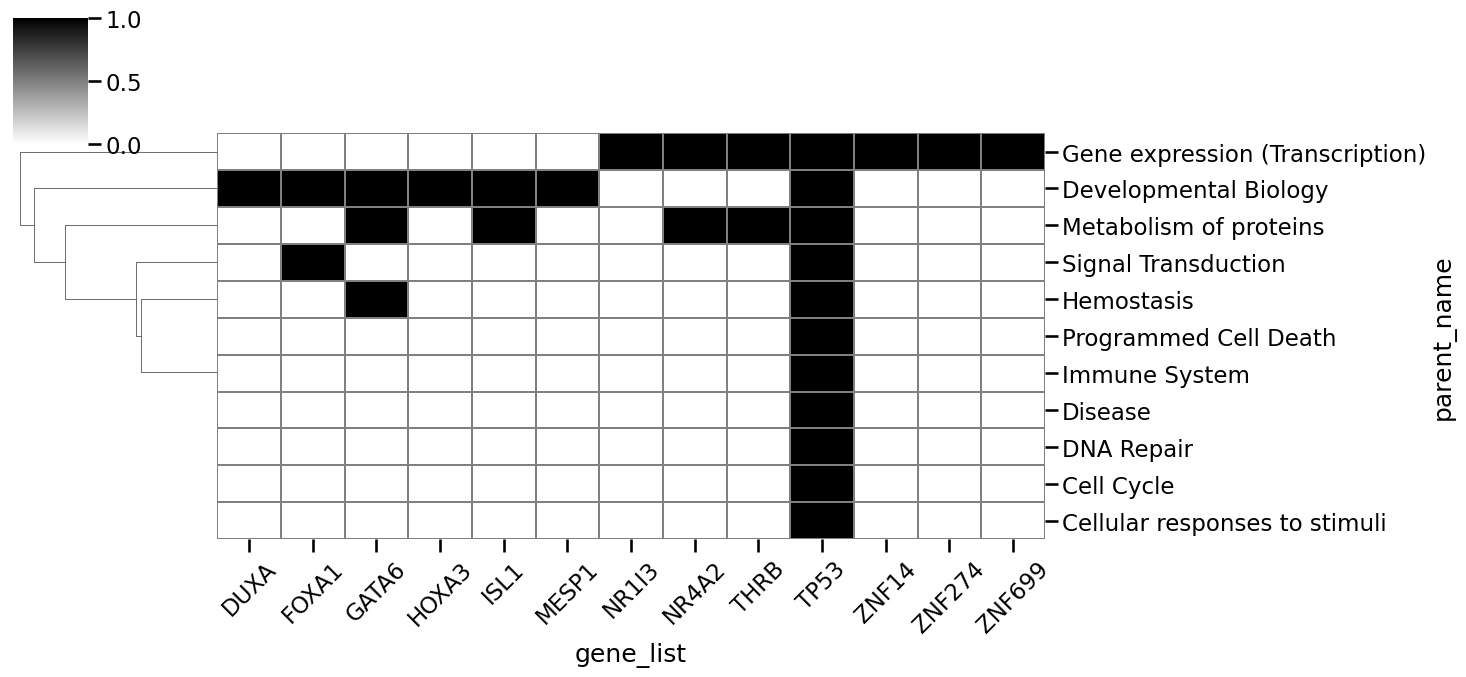

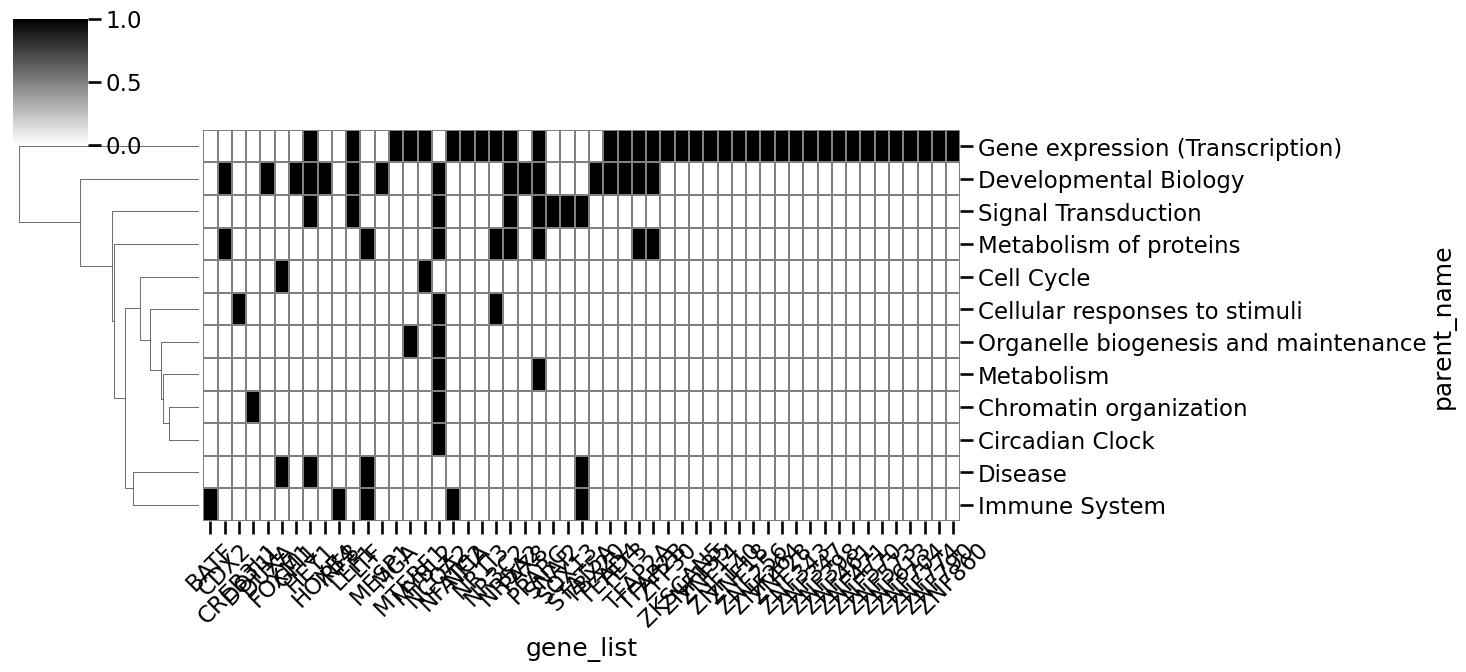

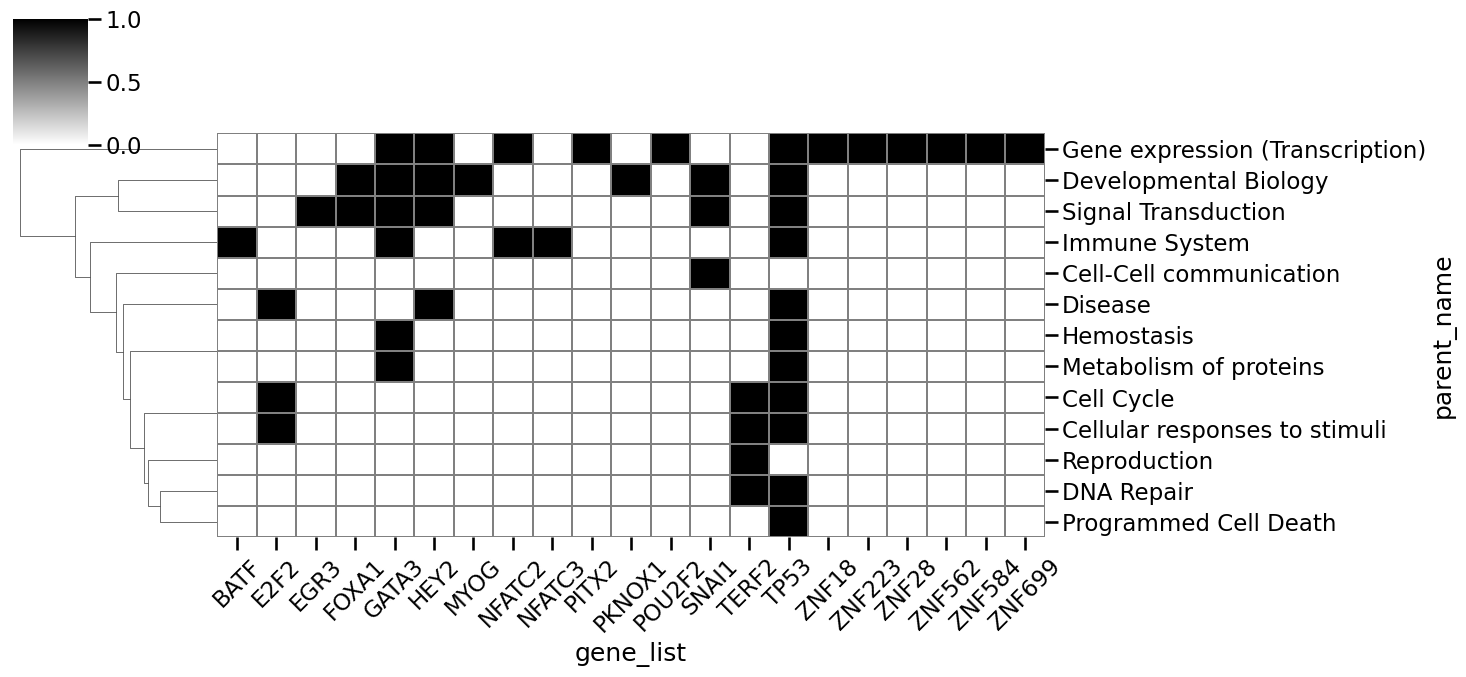

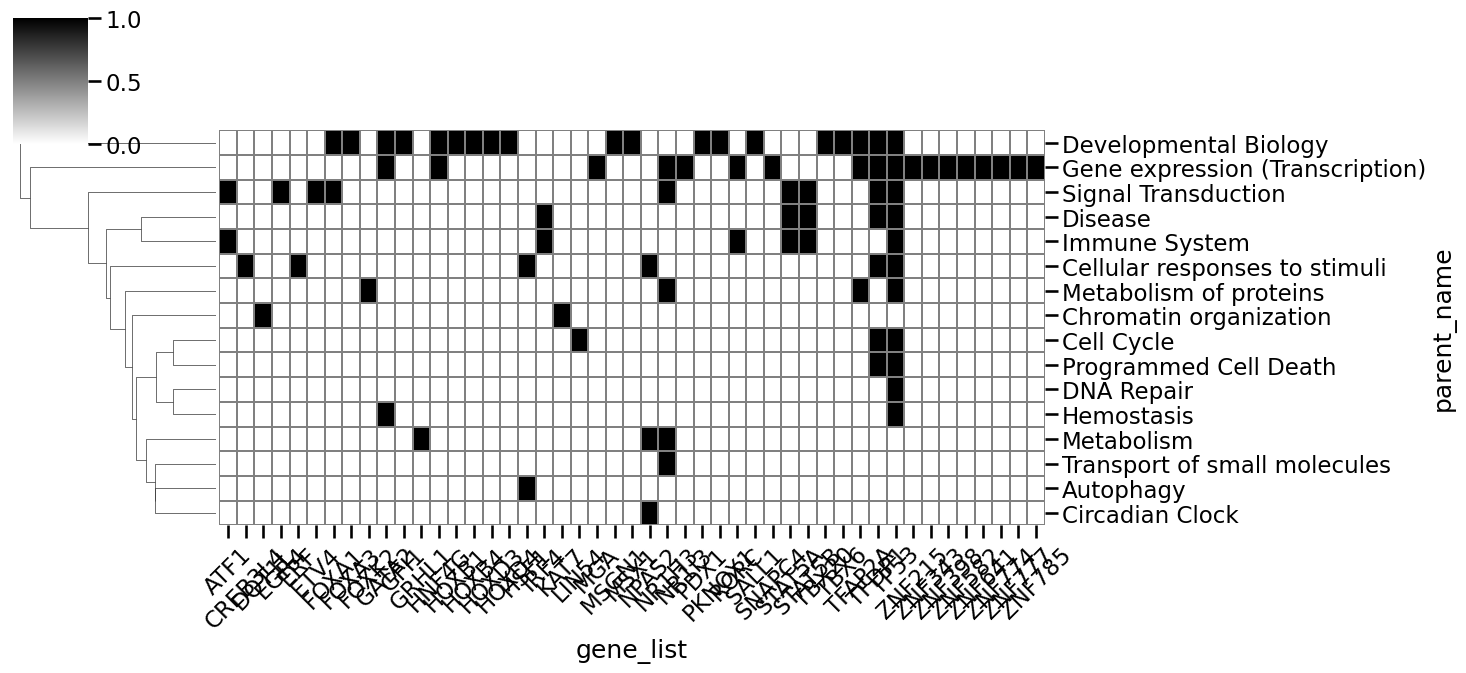

In [34]:
for key, items in res_all.items():
    print(key)
    res_all[key].res2d['gene_list'] = [i.split(';') for i in res_all[key].res2d.Genes]
    print(res_all[key].res2d.head())
    myres = (res_all[key].res2d.merge(hierarchy, left_on='Term', right_on = 'child_name')).copy()
    mytab = pd.pivot_table(myres.explode('gene_list'), index = 'parent_name', columns= 'gene_list', values='P-value')
    #notp53 = list(set(mytab.columns.tolist()).difference(set(['TP53'])))
    #mytab = mytab.loc[:,notp53].dropna(axis = 0,how = 'all').fillna(1)

    mytab_genes = mytab.columns
    mytab_full = mytab.dropna(axis = 0,how = 'all').fillna(1)#mytab.merge(hierarchy, left_index=True, right_on = 'child_name').set_index('child_name')

    column = mytab_full.index
    cmap = cm.get_cmap('Set3', len(column.unique()))
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    lut = dict(zip(column.unique(), color_list))
    row_colors = column.map(lut)
    sns.set_context('talk')
    # white line for the clustermap

    current_data = 1*(mytab_full.loc[:,mytab_genes]<1)
    g1 = sns.clustermap(current_data, yticklabels = 1, xticklabels = 1, col_cluster=False, figsize=(15,7), lw = .2, cmap = 'binary', **{'linecolor':'grey'})
    plt.setp(g1.ax_heatmap.xaxis.get_majorticklabels(), rotation=45)


    from matplotlib.patches import Patch

    #handles = [Patch(facecolor=lut[name]) for name in lut]
    #plt.legend(handles, lut, title='Species',
    #        bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

    g1.fig.savefig(output_folder+'all_cms_parent_tfs_all_clustermap_cluster%s.pdf' %key, bbox_inches = 'tight')

We can also look at the pathway analysis in a qualitative way, by checking the actual p-values. 

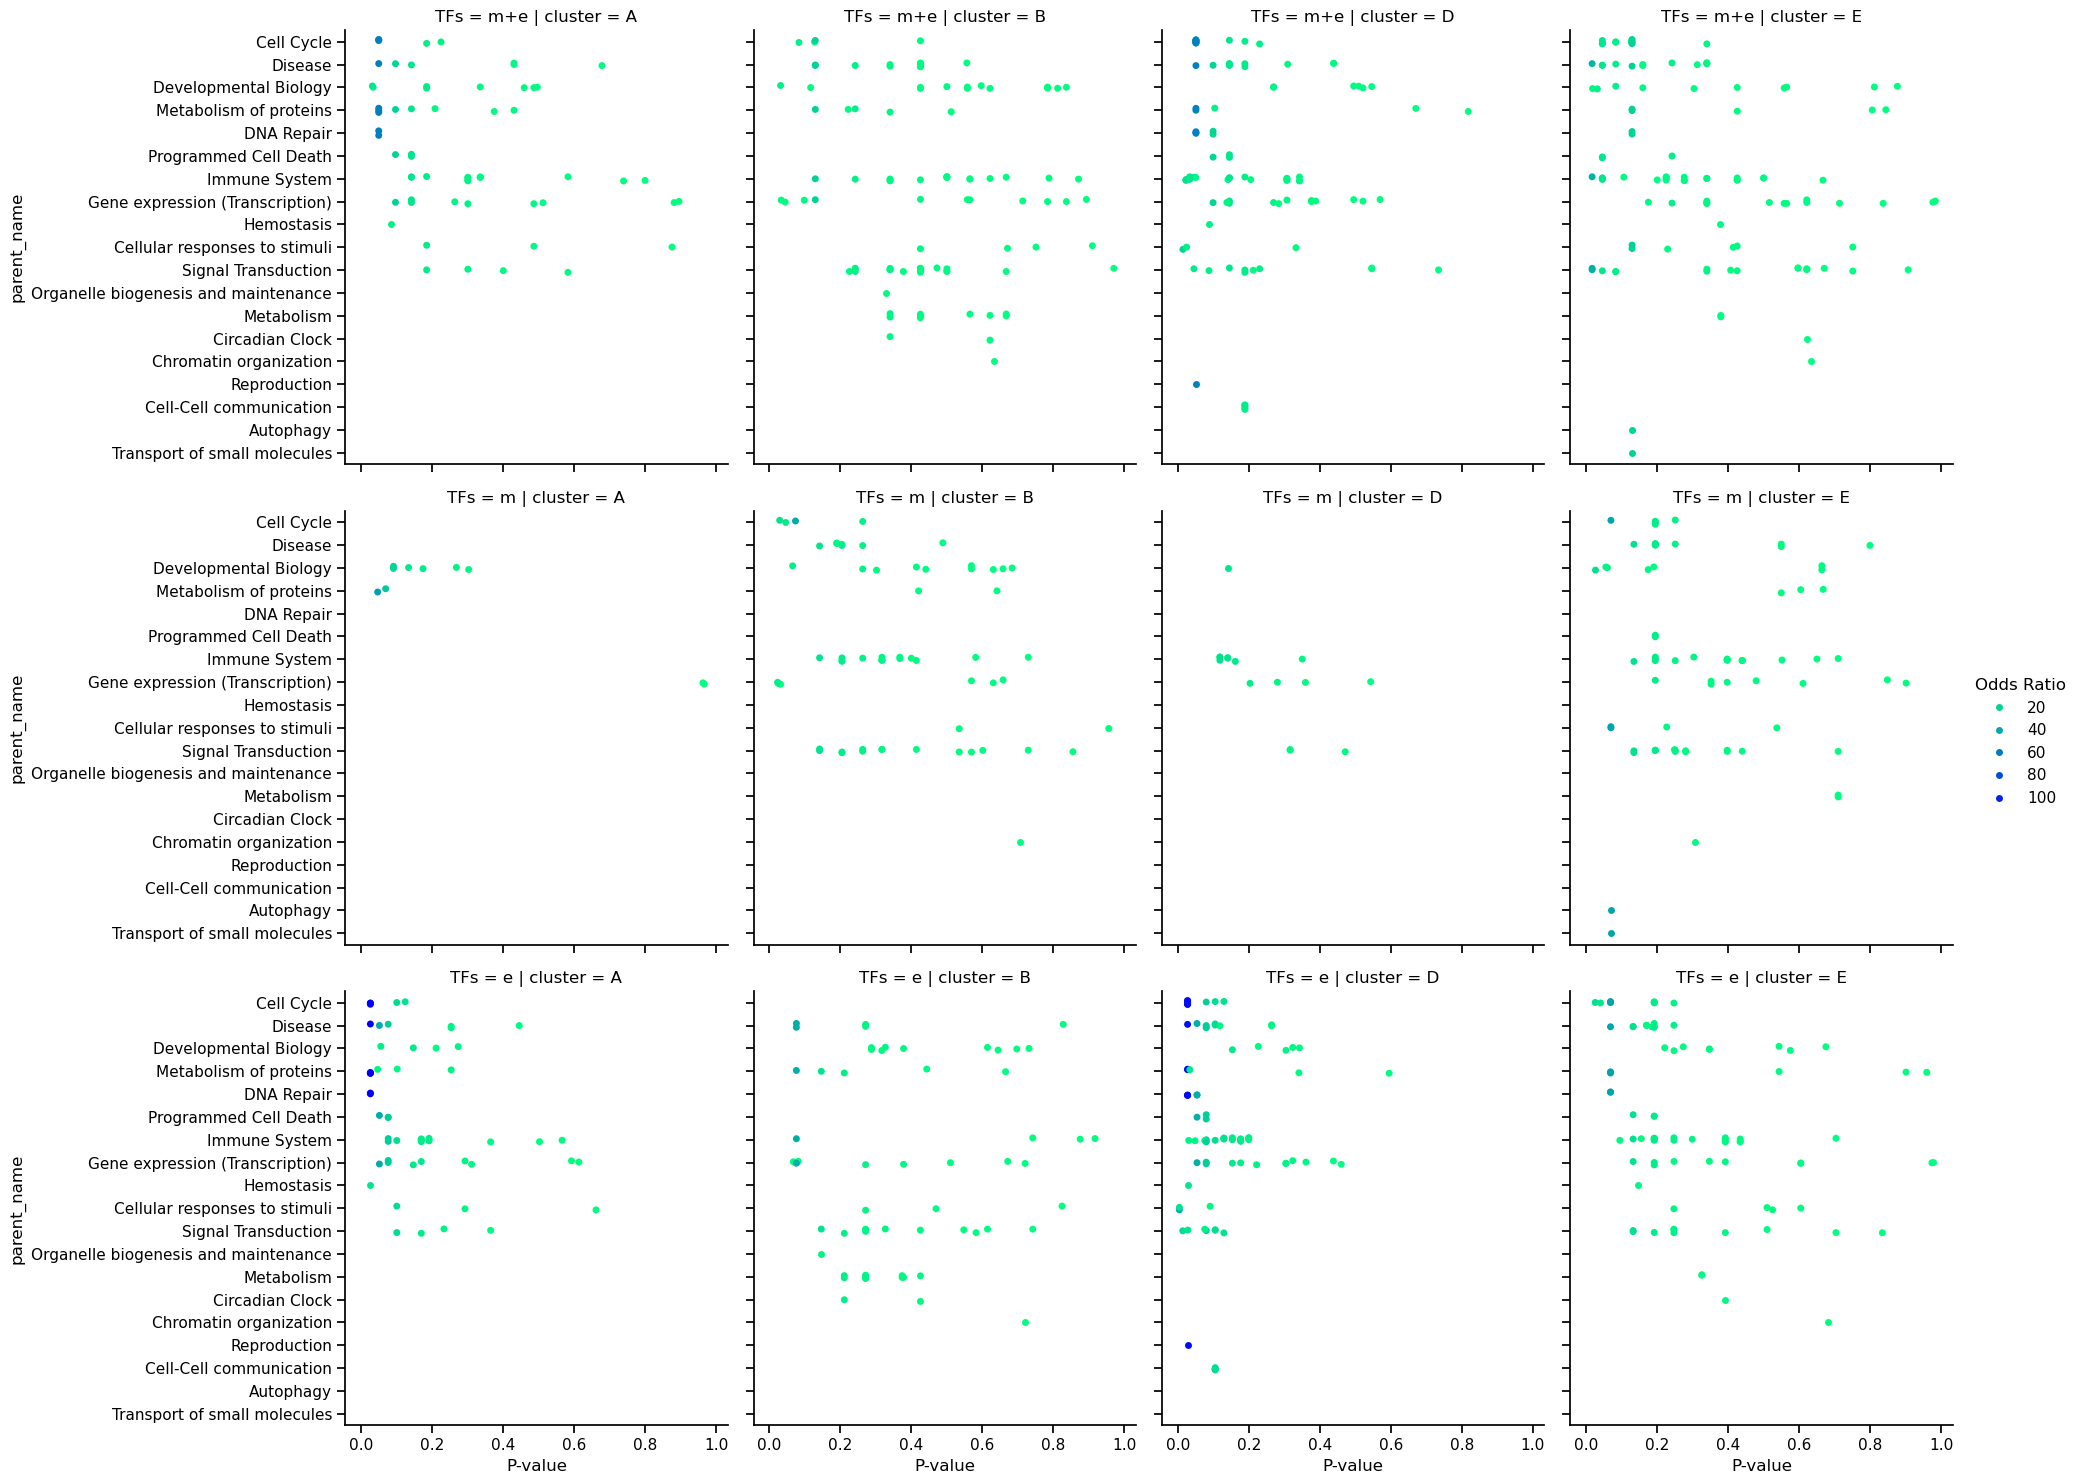

In [35]:
res_14 = pd.DataFrame()
for i in res_all.keys():
    for rrr,tab in {'m+e':res_all, 'm':res_meth, 'e': res_expr}.items():
        temp = tab[i].res2d.merge(hierarchy, left_on = 'Term', right_on = 'child_name').sort_values(by = 'Adjusted P-value')
        temp['cluster'] = str(i)
        temp['TFs'] = rrr
        res_14 = pd.concat([res_14, temp], axis = 0)
        
sns.set_context('notebook')
g1 = sns.catplot(x = 'P-value', y = 'parent_name', data = res_14, hue = 'Odds Ratio', col ='cluster', row = 'TFs', palette='winter_r')
g1.fig.savefig(output_folder + 'all_cms_reactome_parents_bycluster.pdf')

For simplicity, let's clean the figure above and keep only the clusters we are interested in

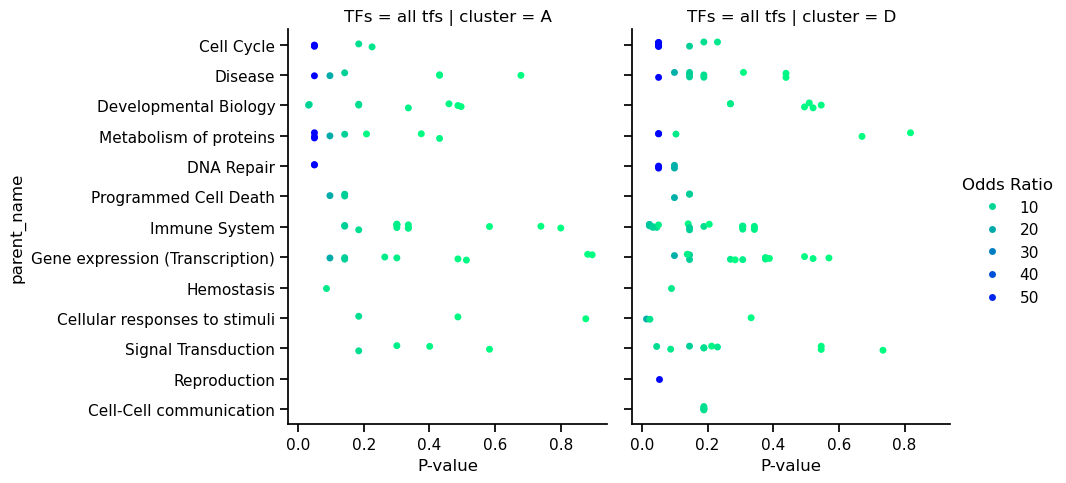

In [36]:
# NOW WE CLEAN THE ONE ABOVE
res_14 = pd.DataFrame()
for i in ['A','D']:
    for rrr,tab in {'all tfs':res_all}.items():
        temp = tab[i].res2d.merge(hierarchy, left_on = 'Term', right_on = 'child_name').sort_values(by = 'Adjusted P-value')
        temp['cluster'] = str(i)
        temp['TFs'] = rrr
        res_14 = pd.concat([res_14, temp], axis = 0)
        
sns.set_context('notebook')
g1 = sns.catplot(x = 'P-value', y = 'parent_name', data = res_14, hue = 'Odds Ratio', col ='cluster', row = 'TFs', palette='winter_r')
g1.fig.savefig(output_folder + 'all_cms_reactome_parents_bycluster_ADonly.pdf')